In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Goal

The goal of this notebook is to answer "What is the future depth of a well belonging to the aquifer in Doganella over the next quarter?".

The wells field Doganella is fed by two underground aquifers not fed by rivers or lakes but fed by meteoric infiltration. The upper aquifer is a water table with a thickness of about 30m. The lower aquifer is a semi-confined artesian aquifer with a thickness of 50m and is located inside lavas and tufa products. These aquifers are accessed through wells called Well 1, ..., Well 9. Approximately 80% of the drainage volumes come from the artesian aquifer. The aquifer levels are influenced by the following parameters: rainfall, humidity, subsoil, temperatures and drainage volumes.

A semi-confined artesian aquifer means that the aquifer is under positive pressure from semi-impermeable material and the well would have water reach ground level under natural pressure.

# Doganella Aquifer: Data Preprocessing

In [2]:
doganella = pd.read_csv('../input/acea-water-prediction/Aquifer_Doganella.csv')
doganella.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6026 entries, 0 to 6025
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          6026 non-null   object 
 1   Rainfall_Monteporzio          5399 non-null   float64
 2   Rainfall_Velletri             5374 non-null   float64
 3   Depth_to_Groundwater_Pozzo_1  2537 non-null   float64
 4   Depth_to_Groundwater_Pozzo_2  2736 non-null   float64
 5   Depth_to_Groundwater_Pozzo_3  2774 non-null   float64
 6   Depth_to_Groundwater_Pozzo_4  2374 non-null   float64
 7   Depth_to_Groundwater_Pozzo_5  2508 non-null   float64
 8   Depth_to_Groundwater_Pozzo_6  2428 non-null   float64
 9   Depth_to_Groundwater_Pozzo_7  2311 non-null   float64
 10  Depth_to_Groundwater_Pozzo_8  2551 non-null   float64
 11  Depth_to_Groundwater_Pozzo_9  2339 non-null   float64
 12  Volume_Pozzo_1                1356 non-null   float64
 13  Vol

For time series data, we need to make sure that the dataset is in chronological order and equidistant in time for each entry. This dataset fulfills both of these conditions already and each entry is one day and the time period spans from 1/1/2004 to 30/6/2020.

In [3]:
doganella['Date'] = pd.to_datetime(doganella.Date, format='%d/%m/%Y')
doganella.tail().style.set_properties(subset=['Date'], **{'background-color':'orange'})

### Features:
* **Rainfall** is the amount of rain falling in area X in mm
* **Temperature** is temperature in area Y in C
* **Volume** is the amount of water take from a drinking water treatment plant in m^{3}

### Target:
* **Depth to Groundwater** which is the depth to the water from the ground floor in m

Now I will plot the features during the full time period to gain an understanding of any repeating patterns or interesting occurrences.

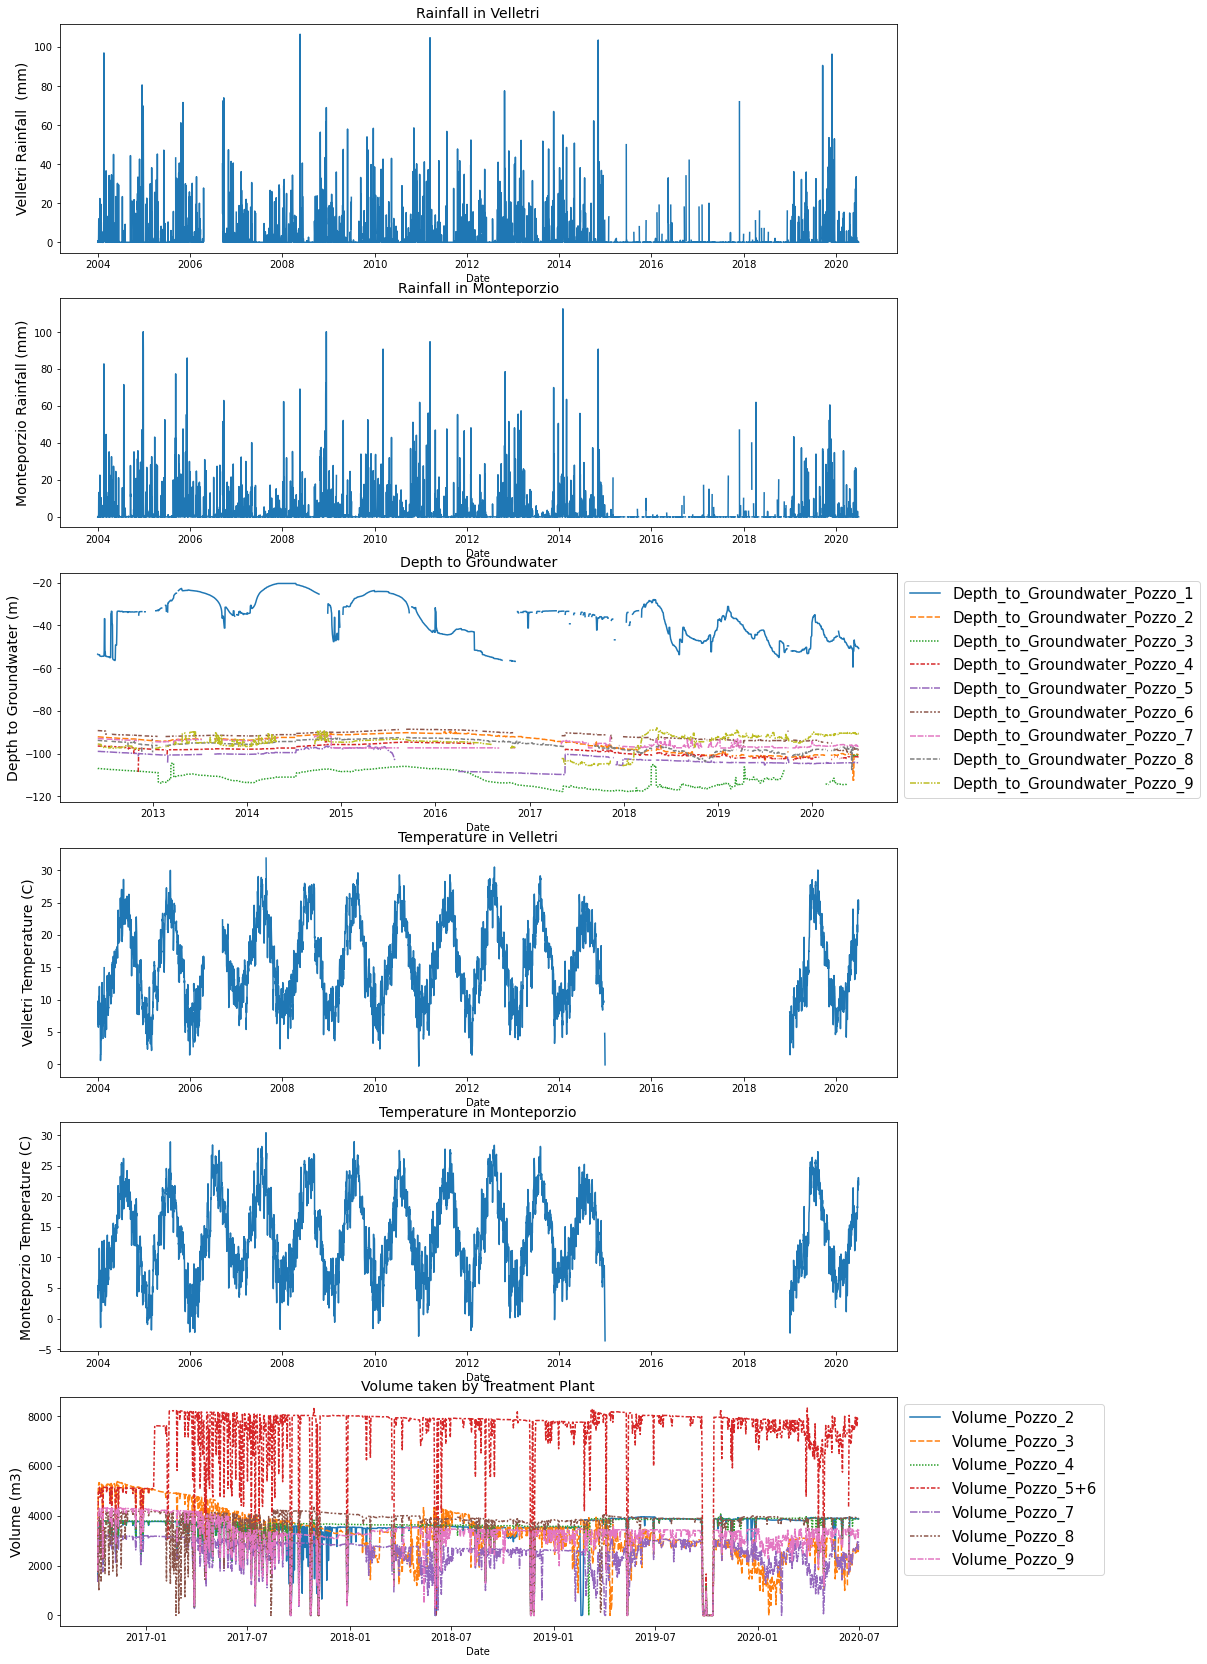

In [4]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 25))
plt.subplots_adjust(bottom=0.01, top=0.9)

sns.lineplot(x=doganella['Date'], y=doganella['Rainfall_Velletri'].fillna(np.inf), ax=ax[0])
ax[0].set_title('Rainfall in Velletri', fontsize=14)
ax[0].set_ylabel('Velletri Rainfall  (mm)', fontsize=14)

sns.lineplot(x=doganella['Date'], y=doganella['Rainfall_Monteporzio'].fillna(np.inf), ax=ax[1])
ax[1].set_title('Rainfall in Monteporzio', fontsize=14)
ax[1].set_ylabel('Monteporzio Rainfall (mm)', fontsize=14)

groundwater_data = doganella.iloc[:, np.r_[0,3:12]].set_index('Date').fillna(np.inf)
sns.lineplot(data=groundwater_data, ax=ax[2])
ax[2].set_title('Depth to Groundwater', fontsize=14)
ax[2].set_ylabel('Depth to Groundwater (m)', fontsize=14)
ax[2].legend(bbox_to_anchor=(1,1), loc='upper left', prop={'size':15})

sns.lineplot(x=doganella['Date'], y=doganella['Temperature_Velletri'].fillna(np.inf), ax=ax[3])
ax[3].set_title('Temperature in Velletri', fontsize=14)
ax[3].set_ylabel('Velletri Temperature (C)', fontsize=14)

sns.lineplot(x=doganella['Date'], y=doganella['Temperature_Monteporzio'].fillna(np.inf), ax=ax[4])
ax[4].set_title('Temperature in Monteporzio', fontsize=14)
ax[4].set_ylabel('Monteporzio Temperature (C)', fontsize=14)

vol_columns = doganella.iloc[:, np.r_[0,13:20]].set_index('Date').fillna(np.inf)
sns.lineplot(data=vol_columns, ax=ax[5])
ax[5].set_title('Volume taken by Treatment Plant', fontsize=14)
ax[5].set_ylabel('Volume (m3)', fontsize=14)
ax[5].legend(bbox_to_anchor=(1,1), loc='upper left', prop={'size':15})

plt.show()

Visualizing the data and filling in the NaN values with infinity reveals some gaps in the data for certain years. The temperature is missing a lot of values between the years of 2015 and 2018 and the depth to groundwater also has some gaps in it as well. 

In [5]:
temp = doganella[['Date','Temperature_Velletri']].loc[(doganella['Date'] >= '01-01-2015') & (doganella['Date'] < '30-12-2018')]
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 4018 to 5476
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1459 non-null   datetime64[ns]
 1   Temperature_Velletri  23 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 34.2 KB


This shows that during the years from 2015-2018 there were only 23 recorded values for the temperature.

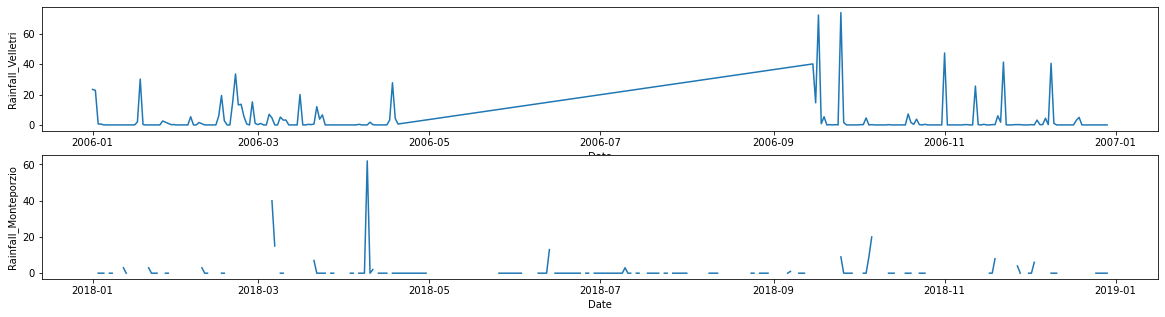

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,5))

velletri = doganella[['Date','Rainfall_Velletri']].loc[(doganella['Date'] >= '01-01-2006') & (doganella['Date'] < '30-12-2006')]
sns.lineplot(x=velletri.Date, y=velletri.Rainfall_Velletri, ax=ax[0])

monteporzio = doganella[['Date','Rainfall_Monteporzio']].loc[(doganella['Date'] >= '01-01-2018') & (doganella['Date'] < '30-12-2018')]
sns.lineplot(x=monteporzio.Date, y=monteporzio.Rainfall_Monteporzio.fillna(np.inf), ax=ax[1])

plt.show()

In the plots shown for all the features, I had to change the NaN values to infinity because it caused an odd plot as shown above for Velletri. After looking into it more it appears that Velletri has a gap in the data from 21/04/2006 to 12/09/2006, then had a recorded rainfall of 74 mm on 16/09/2006. This caused the plot to plot a straight line from 0 to 74 across this gap.

In the rainfall for Monteperizo, changing the NaN values actually caused gaps in the data when plotted which revealed more NaN values. The most apparent ones happened in the year of 2018.

In [7]:
velletri_nan = doganella[['Date','Rainfall_Velletri']].loc[(doganella['Date'] >= '04-21-2006') & (doganella['Date'] < '15-09-2006')]
velletri_nan.info()

monteperizo_discrep = doganella[['Date','Rainfall_Monteporzio']].loc[(doganella['Date'] >= '01-01-2018') & (doganella['Date'] < '30-12-2018')]
monteperizo_discrep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 841 to 987
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               147 non-null    datetime64[ns]
 1   Rainfall_Velletri  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 5114 to 5476
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  363 non-null    datetime64[ns]
 1   Rainfall_Monteporzio  183 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.5 KB


This shows that between 21/4/2006 and 15/9/2006 there are no values which were recorded in Velletri. It is unlikely that there was no rain for 5 months of the year when all of the other years have a recorded instance of 0 mm or more. It also appears that the rainfall in Monteperizo is missing about half of the values for the year of 2018 as well. These discrpancies will need to be addressed.

The graphs below show all of the missing values in the dataset for every feature.

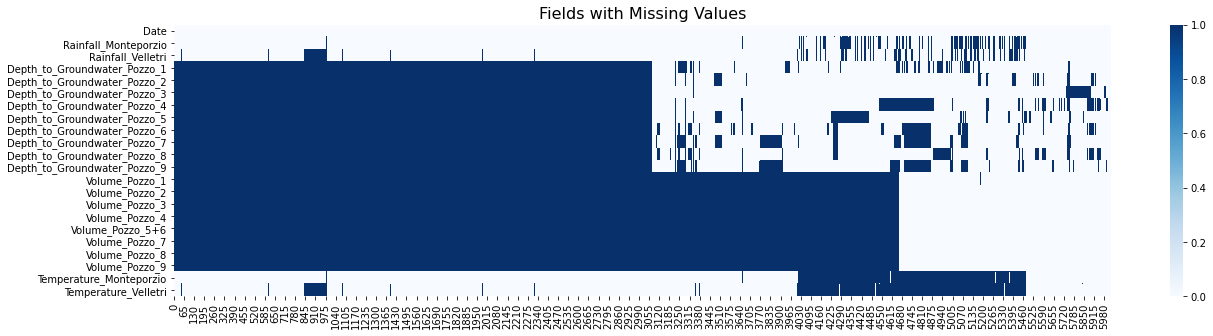

In [8]:
fig, ax = plt.subplots(1,1,figsize=(21,5))
sns.heatmap(doganella.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
plt.show()

It appears that the depth to groundwater wasn't starting to be recorded until about 2012 and the volume was not recorded until 2016. There are also large gaps in the temperature which was recorded as well from 2015 to 2018. 

The gaps in the data for the features could be addressed by interpolating the points, but this does create some unrealistic data for the big gaps for temperature and rainfall. It also may cause inaccuracies when predicting since some of the newer values for depth to groundwater will be interpolated values instead of recorded values.

However, to make the best use of the data I believe that dropping the dates before depth to groundwater began to be recorded would help with prediction and model interpretability since we would not be able to tell how features affected depth to groundwater during that period of time. It is mentioned that rainfall and temperature may have a delayed effect on depth to groundwater though, so a year before when depth to groundwater is first recorded will be used in the dataset. After dropping these values, then the rest of the NaN values will be filled using interpolation. 

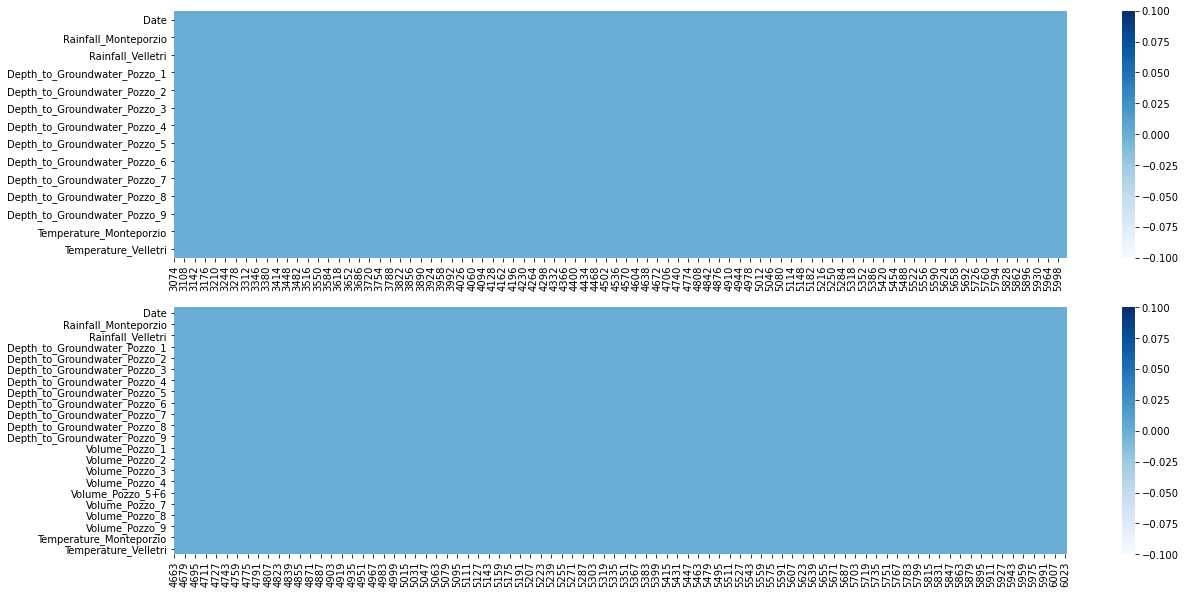

In [9]:
dog_no_vol = doganella.iloc[:, np.r_[0:12,20,21]].interpolate().dropna()
dog = doganella.interpolate().dropna()

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.heatmap(dog_no_vol.T.isna(), cmap='Blues', ax=ax[0])
sns.heatmap(dog.T.isna(), cmap='Blues', ax=ax[1])
plt.show()

Now the dataset is clean and does not contain any NaN values. Another issue which may need to be addressed is when the drainage volumes are 0 since it seems odd that multiple water treatment facilities would not have any water pulled from them for multiple days at a time.

## Interpolation Method

The interpolation method used will be linear since the time method and the linear method are equivalent for the dataset. This is because the dataset is already equally spaced. I will visualize how the interpolation method affects all of the features when it is used to gain a more intuitive understanding of what it is doing.

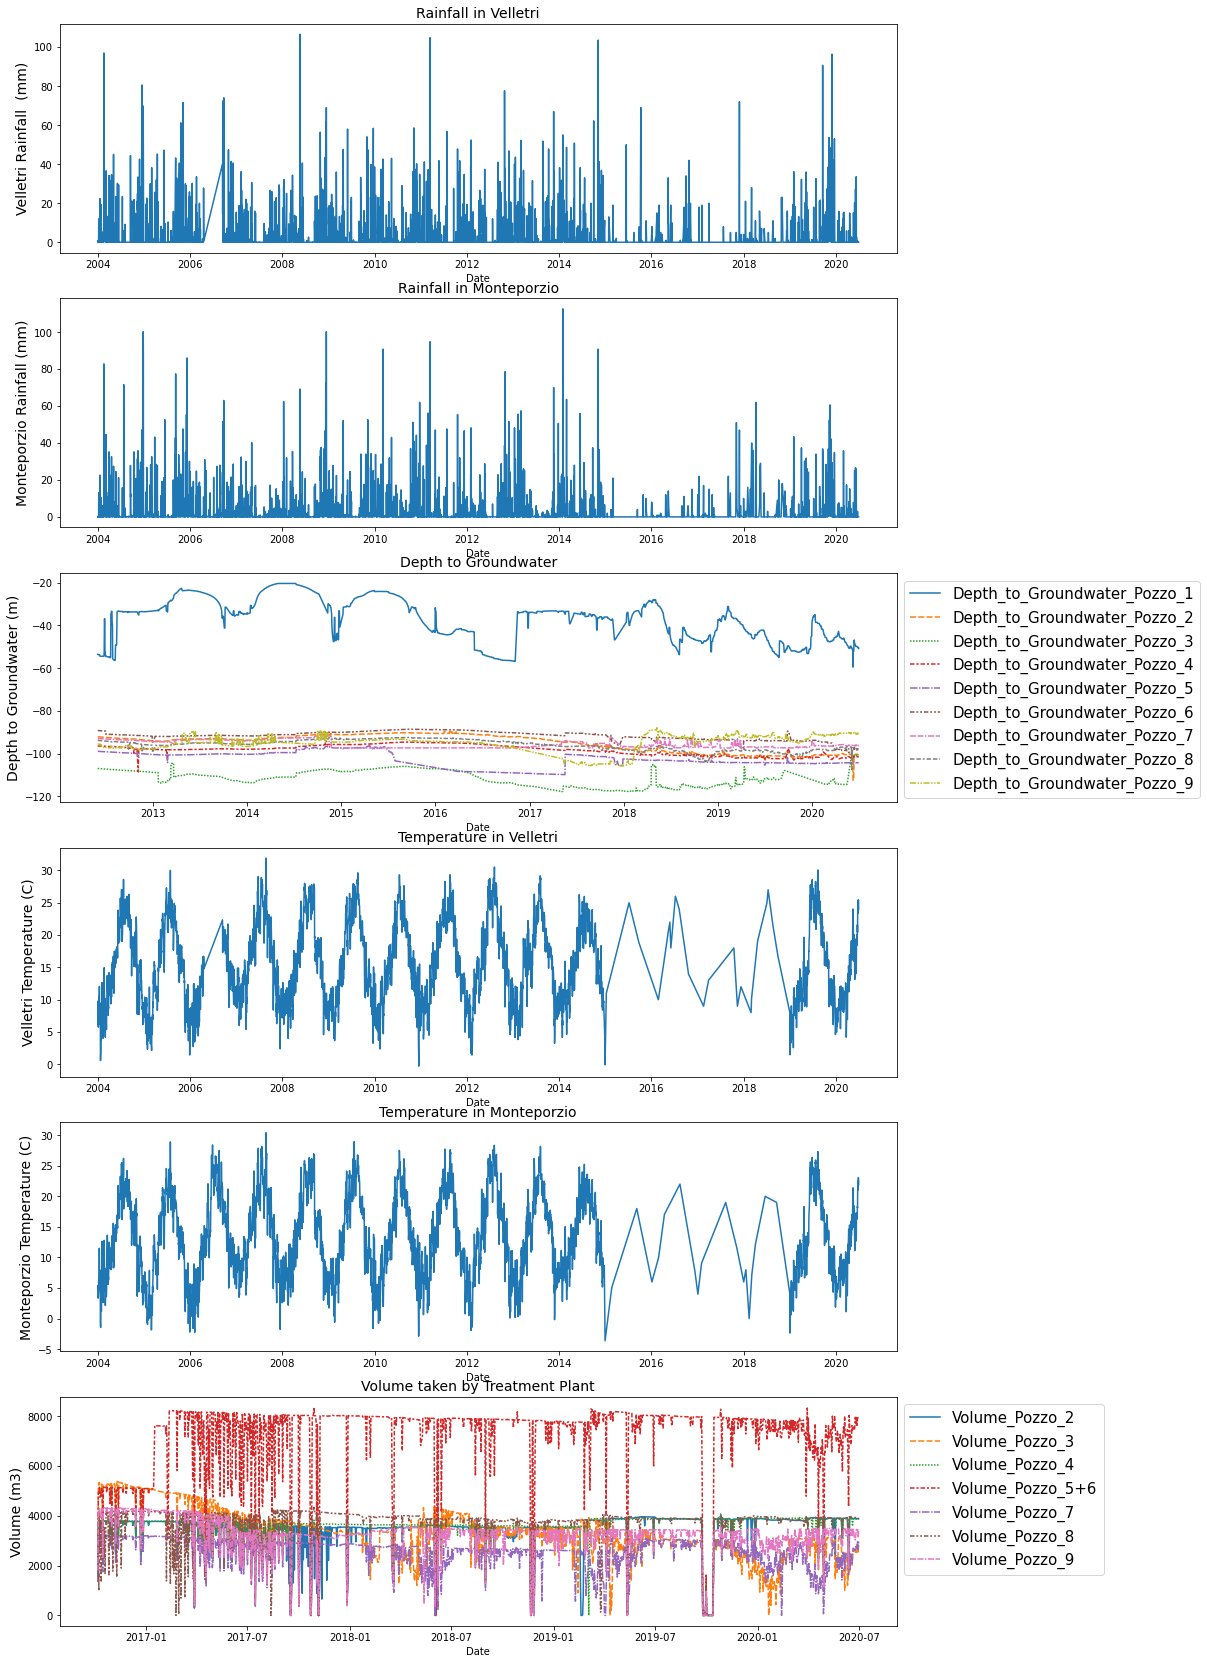

In [10]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 25))
plt.subplots_adjust(bottom=0.01, top=0.9)

sns.lineplot(x=doganella['Date'], y=doganella['Rainfall_Velletri'].interpolate(), ax=ax[0])
ax[0].set_title('Rainfall in Velletri', fontsize=14)
ax[0].set_ylabel('Velletri Rainfall  (mm)', fontsize=14)

sns.lineplot(x=doganella['Date'], y=doganella['Rainfall_Monteporzio'].interpolate(), ax=ax[1])
ax[1].set_title('Rainfall in Monteporzio', fontsize=14)
ax[1].set_ylabel('Monteporzio Rainfall (mm)', fontsize=14)

groundwater_data = doganella.iloc[:, np.r_[0,3:12]].set_index('Date').interpolate()
sns.lineplot(data=groundwater_data, ax=ax[2])
ax[2].set_title('Depth to Groundwater', fontsize=14)
ax[2].set_ylabel('Depth to Groundwater (m)', fontsize=14)
ax[2].legend(bbox_to_anchor=(1,1), loc='upper left', prop={'size':15})

sns.lineplot(x=doganella['Date'], y=doganella['Temperature_Velletri'].interpolate(), ax=ax[3])
ax[3].set_title('Temperature in Velletri', fontsize=14)
ax[3].set_ylabel('Velletri Temperature (C)', fontsize=14)

sns.lineplot(x=doganella['Date'], y=doganella['Temperature_Monteporzio'].interpolate(), ax=ax[4])
ax[4].set_title('Temperature in Monteporzio', fontsize=14)
ax[4].set_ylabel('Monteporzio Temperature (C)', fontsize=14)

vol_columns = doganella.iloc[:, np.r_[0,13:20]].set_index('Date').interpolate()
sns.lineplot(data=vol_columns, ax=ax[5])
ax[5].set_title('Volume taken by Treatment Plant', fontsize=14)
ax[5].set_ylabel('Volume (m3)', fontsize=14)
ax[5].legend(bbox_to_anchor=(1,1), loc='upper left', prop={'size':15})

plt.show()

As you can see, it gives semi-accurate guesses for the missing values, but it is hard for the large gaps in the temperature and rainfall. Another way to slice this dataset to make it more accurate may be to just use the time periods where there are not large gaps and test the model with those time periods. This may be pursued at a later time.

We could also try to downsample the data to try to fill in the blanks. I will downsample the data to weekly data since we are trying to find predict the depth to groundwater for each month. This will not lose too much granularity and may help fill in some of the blanks.

In [11]:
dog_no_vol_downsampled = dog_no_vol.iloc[:, np.r_[0, 3:14]].resample('7D', on='Date').mean().reset_index(drop=False)

dog_no_vol_downsampled[['Rainfall_Velletri', 'Rainfall_Monteporzio']] = dog_no_vol[['Date', 
                                                          'Rainfall_Velletri', 
                                                          'Rainfall_Monteporzio']].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall_Velletri',
                                                                                                                                            'Rainfall_Monteporzio']]
display(dog_no_vol_downsampled.head())

Date  Depth_to_Groundwater_Pozzo_1  Depth_to_Groundwater_Pozzo_2  \
0 2012-06-01                    -53.658571                    -92.210000   
1 2012-06-08                    -54.282857                    -92.271429   
2 2012-06-15                    -54.431429                    -92.355714   
3 2012-06-22                    -49.052857                    -92.410000   
4 2012-06-29                    -53.730000                    -92.445714   

   Depth_to_Groundwater_Pozzo_3  Depth_to_Groundwater_Pozzo_4  \
0                   -106.992857                    -96.517143   
1                   -107.055714                    -96.541429   
2                   -107.155714                    -96.535714   
3                   -107.224286                    -96.625714   
4                   -107.291429                    -96.565714   

   Depth_to_Groundwater_Pozzo_5  Depth_to_Groundwater_Pozzo_6  \
0                    -99.002857                    -89.271429   
1                    -99.042857                    -89.330000   
2                    -99.092857                    -89.395714   
3                    -99.128571                    -89.447143   
4                    -99.174286                    -90.310000   

   Depth_to_Groundwater_Pozzo_7  Depth_to_Groundwater_Pozzo_8  \
0                    -92.962857                    -93.854286   
1                    -93.018571                    -93.920000   
2                    -93.091429                    -94.014286   
3                    -93.144286                    -94.074286   
4                    -93.190000                    -94.114286   

   Depth_to_Groundwater_Pozzo_9  Temperature_Monteporzio  \
0                    -95.568571                18.301429   
1                    -95.691429                19.311429   
2                    -96.988571                24.652857   
3                    -96.931429                24.544286   
4                    -96.912857                24.424286   

   Temperature_Velletri  Rainfall_Velletri  Rainfall_Monteporzio  
0             19.740000               12.8                   1.2  
1             20.857143                0.0                   0.4  
2             25.988571                0.0                   0.0  
3             26.532857                0.0                   0.0  
4             26.244286                0.0                   0.2

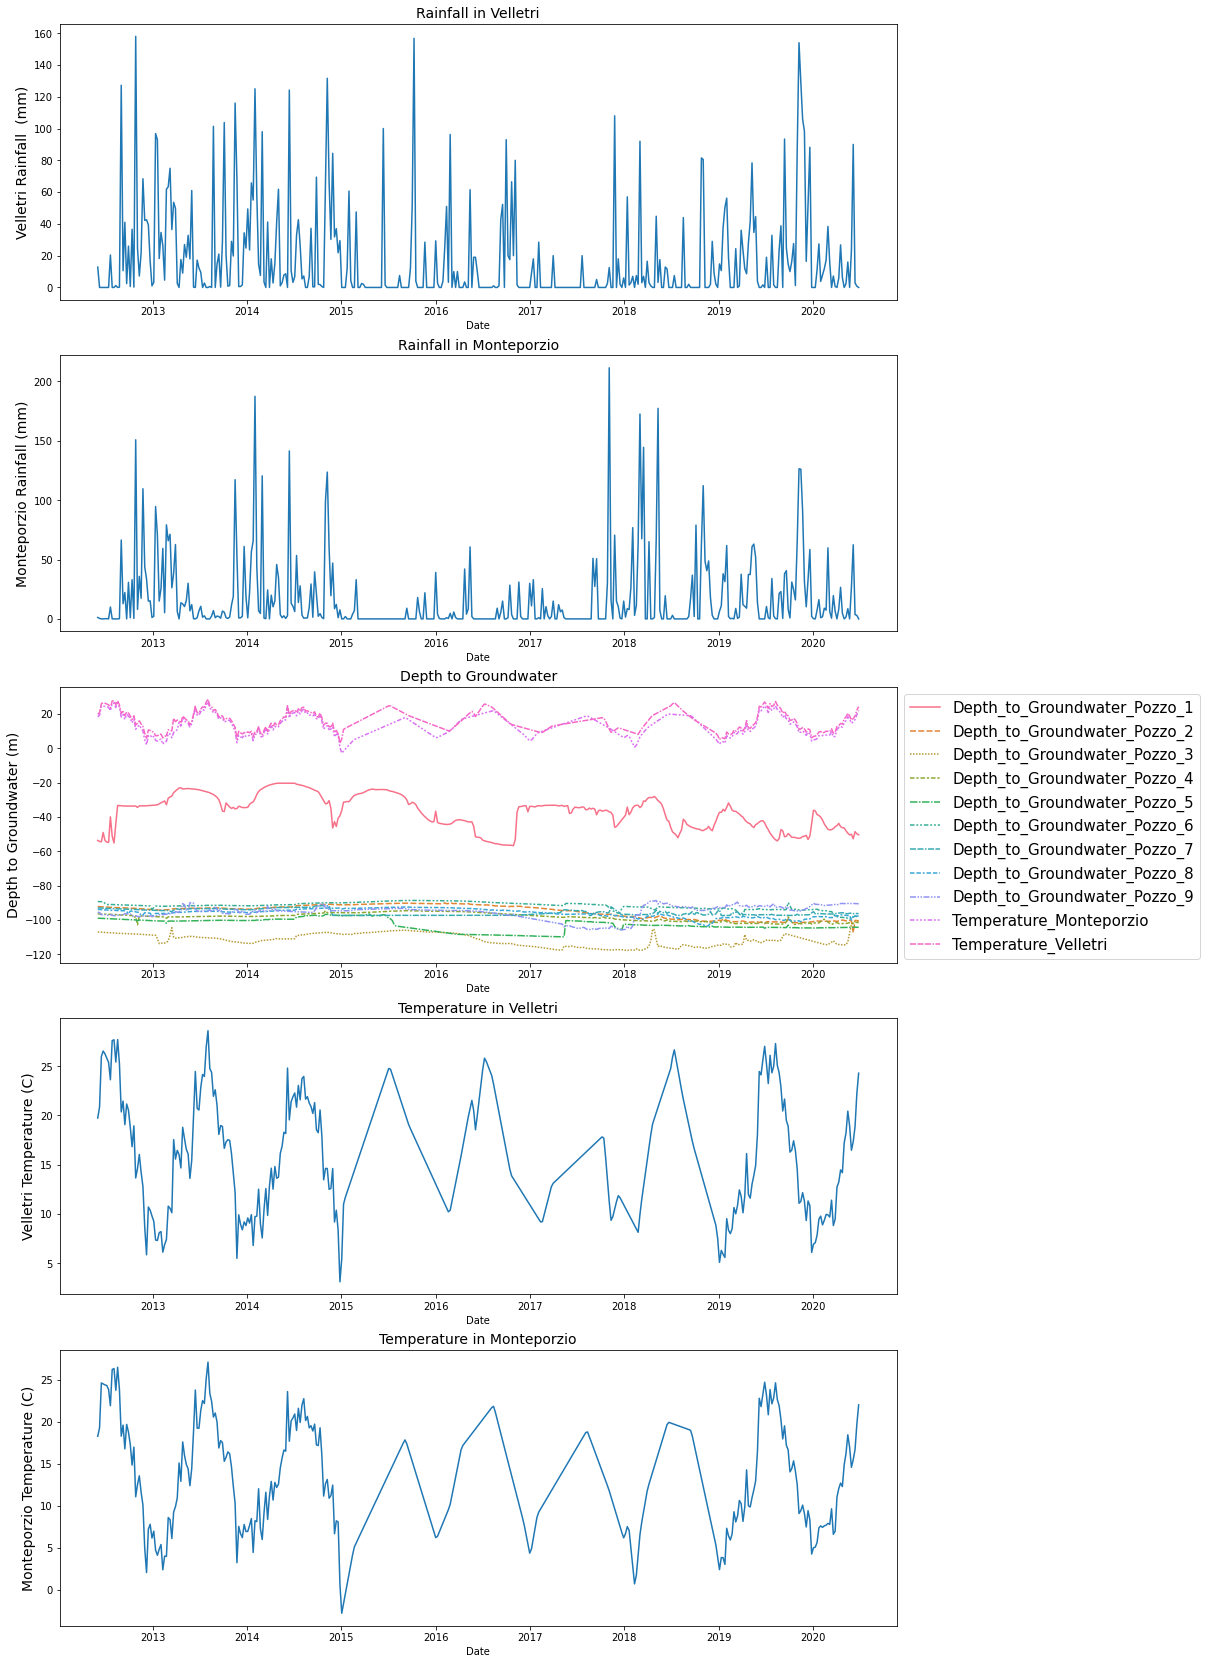

In [12]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
plt.subplots_adjust(bottom=0.01, top=0.9)

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Velletri'], ax=ax[0])
ax[0].set_title('Rainfall in Velletri', fontsize=14)
ax[0].set_ylabel('Velletri Rainfall  (mm)', fontsize=14)

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Monteporzio'], ax=ax[1])
ax[1].set_title('Rainfall in Monteporzio', fontsize=14)
ax[1].set_ylabel('Monteporzio Rainfall (mm)', fontsize=14)

groundwater_data = dog_no_vol_downsampled.iloc[:, np.r_[0,1:12]].set_index('Date')
sns.lineplot(data=groundwater_data, ax=ax[2])
ax[2].set_title('Depth to Groundwater', fontsize=14)
ax[2].set_ylabel('Depth to Groundwater (m)', fontsize=14)
ax[2].legend(bbox_to_anchor=(1,1), loc='upper left', prop={'size':15})

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Velletri'], ax=ax[3])
ax[3].set_title('Temperature in Velletri', fontsize=14)
ax[3].set_ylabel('Velletri Temperature (C)', fontsize=14)

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Monteporzio'], ax=ax[4])
ax[4].set_title('Temperature in Monteporzio', fontsize=14)
ax[4].set_ylabel('Monteporzio Temperature (C)', fontsize=14)

plt.show()


Now we will look at the stationarity, seasonality, and trend of the data.

In [13]:
dog_no_vol_downsampled

Date  Depth_to_Groundwater_Pozzo_1  Depth_to_Groundwater_Pozzo_2  \
0   2012-06-01                    -53.658571                    -92.210000   
1   2012-06-08                    -54.282857                    -92.271429   
2   2012-06-15                    -54.431429                    -92.355714   
3   2012-06-22                    -49.052857                    -92.410000   
4   2012-06-29                    -53.730000                    -92.445714   
..         ...                           ...                           ...   
417 2020-05-29                    -50.080000                   -100.411429   
418 2020-06-05                    -52.752857                   -107.317143   
419 2020-06-12                    -48.558571                   -100.304286   
420 2020-06-19                    -49.861429                   -100.350000   
421 2020-06-26                    -50.412000                   -100.518000   

     Depth_to_Groundwater_Pozzo_3  Depth_to_Groundwater_Pozzo_4  \
0                     -106.992857                    -96.517143   
1                     -107.055714                    -96.541429   
2                     -107.155714                    -96.535714   
3                     -107.224286                    -96.625714   
4                     -107.291429                    -96.565714   
..                            ...                           ...   
417                   -102.722143                   -102.028571   
418                   -101.422857                   -102.076667   
419                   -100.912143                   -101.477619   
420                   -100.966429                   -101.478571   
421                   -101.013000                   -101.570000   

     Depth_to_Groundwater_Pozzo_5  Depth_to_Groundwater_Pozzo_6  \
0                      -99.002857                    -89.271429   
1                      -99.042857                    -89.330000   
2                      -99.092857                    -89.395714   
3                      -99.128571                    -89.447143   
4                      -99.174286                    -90.310000   
..                            ...                           ...   
417                   -104.328571                    -99.057143   
418                   -104.308571                    -98.355000   
419                   -104.188571                    -97.738571   
420                   -104.305714                    -98.075714   
421                   -104.302000                    -98.258000   

     Depth_to_Groundwater_Pozzo_7  Depth_to_Groundwater_Pozzo_8  \
0                      -92.962857                    -93.854286   
1                      -93.018571                    -93.920000   
2                      -93.091429                    -94.014286   
3                      -93.144286                    -94.074286   
4                      -93.190000                    -94.114286   
..                            ...                           ...   
417                    -96.065714                   -100.095714   
418                    -96.377143                    -97.482857   
419                    -96.310000                    -97.697143   
420                    -96.245714                    -97.740000   
421                    -96.334000                    -97.772000   

     Depth_to_Groundwater_Pozzo_9  Temperature_Monteporzio  \
0                      -95.568571                18.301429   
1                      -95.691429                19.311429   
2                      -96.988571                24.652857   
3                      -96.931429                24.544286   
4                      -96.912857                24.424286   
..                            ...                      ...   
417                    -90.474286                14.597143   
418                    -90.382857                15.507143   
419                    -90.487143                16.717143   
420                    -90.474286     

## Stationarity, Seasonality, and Trend

Just by looking at the graphs which we made, we can tell that the dataset does not appear to be stationary. There seems to be seasonality in the temperatures which makes sense and the mean rainfall fluctuates as well with some years being drier than others. This means that there is a non-constant mean or a trend for the rainfall and non-constant variance or seasonality for the temperature. We can test this statistically by various methods, but I will use the Augmented Dickey Fuller Test (ADF).

### Augmented Dickey Fuller Test

The ADF tests for a unit root. If the dataset has a unit root then it shows a pattern which may be unpredictable. 

The ADF consists of a Null Hypothesis and Alternate Hypothesis.

**Null Hypothesis:** The time series has a unit root and is not stationary.

**Alternate Hypothesis:** Time series has no unit root and is stationary.



We can reject the null hypothesis based on the p-value or if the test statistic is less than a critical value.

**p-value > 0.05:** Accept the Null Hypothesis and the data is non-stationary.

**p-value < 0.05:** Reject the Null Hypothesis and the data is stationary.

#### OR

**ADF Statistic > Critical Value:** Accept the Null Hypothesis and the data is non-stationary.

**ADF Statistic < Critical Value:** Reject the Null Hypothesis and the data is stationary.

The critical value can be found by looking at a Dickey-Fuller table. The critical value depends on the type of data which we have as well. The critical value will change depending on if the mean is equal to 0 with no trend, the mean is non-zero with no trend, or if the mean is non-zero and has a trend. The critical value changes because we use a different regression equation for each type. So we will first quickly see which type of Dickey-Fuller hypothesis we will use by calculating the mean of each feature. We will also look to see if there is a trend (the mean is changing over time).

In [14]:
dog_no_vol_downsampled.describe()

Depth_to_Groundwater_Pozzo_1  Depth_to_Groundwater_Pozzo_2  \
count                    422.000000                    422.000000   
mean                     -37.010010                    -94.980163   
std                        9.807999                      3.930435   
min                      -56.725714                   -107.317143   
25%                      -44.389286                    -99.232500   
50%                      -34.974286                    -93.433571   
75%                      -30.458929                    -91.600000   
max                      -20.310000                    -89.965714   

       Depth_to_Groundwater_Pozzo_3  Depth_to_Groundwater_Pozzo_4  \
count                    422.000000                    422.000000   
mean                    -111.596646                    -98.292842   
std                        3.722023                      2.360777   
min                     -117.727143                   -102.816571   
25%                     -114.784286                   -100.529643   
50%                     -111.698571                    -97.969144   
75%                     -108.154286                    -96.359422   
max                     -100.912143                    -94.544286   

       Depth_to_Groundwater_Pozzo_5  Depth_to_Groundwater_Pozzo_6  \
count                    422.000000                    422.000000   
mean                    -102.840756                    -91.699596   
std                        3.597081                      2.159424   
min                     -109.874286                    -99.427143   
25%                     -104.573929                    -92.923571   
50%                     -103.101917                    -91.489286   
75%                     -100.212143                    -90.104286   
max                      -96.410000                    -88.611429   

       Depth_to_Groundwater_Pozzo_7  Depth_to_Groundwater_Pozzo_8  \
count                    422.000000                    422.000000   
mean                     -95.677027                    -95.998404   
std                        1.716750                      2.472012   
min                      -97.430000                   -103.582857   
25%                      -97.341289                    -97.924167   
50%                      -96.356101                    -95.592143   
75%                      -93.983571                    -93.927857   
max                      -91.698571                    -92.477143   

       Depth_to_Groundwater_Pozzo_9  Temperature_Monteporzio  \
count                    422.000000               422.000000   
mean                     -95.360186                13.320199   
std                        3.880112                 5.909385   
min                     -105.863846                -2.791154   
25%                      -96.854286                 8.375357   
50%                      -94.610000                13.177857   
75%                      -93.002143                17.952026   
max                      -88.665714                27.132857   

       Temperature_Velletri  Rainfall_Velletri  Rainfall_Monteporzio  
count            422.000000         422.000000            422.000000  
mean              16.001527          18.050000             16.805924  
std                5.519474          30.171363             31.321414  
min                3.132071           0.000000              0.000000  
25%               11.336172           0.000000              0.000000  
50%               15.656552           2.200000              2.000000  
75%               20.453571          23.550000             18.968750  
max               28.595714         158.000000            211.400000

So we can see that none of the means are equal to 0, now we will see if the mean changes over time by graphing the mean of each year. Since we want to test if our dataset over multiple years is stationary, then looking at how the mean changes each year is a good way to check for constant mean.

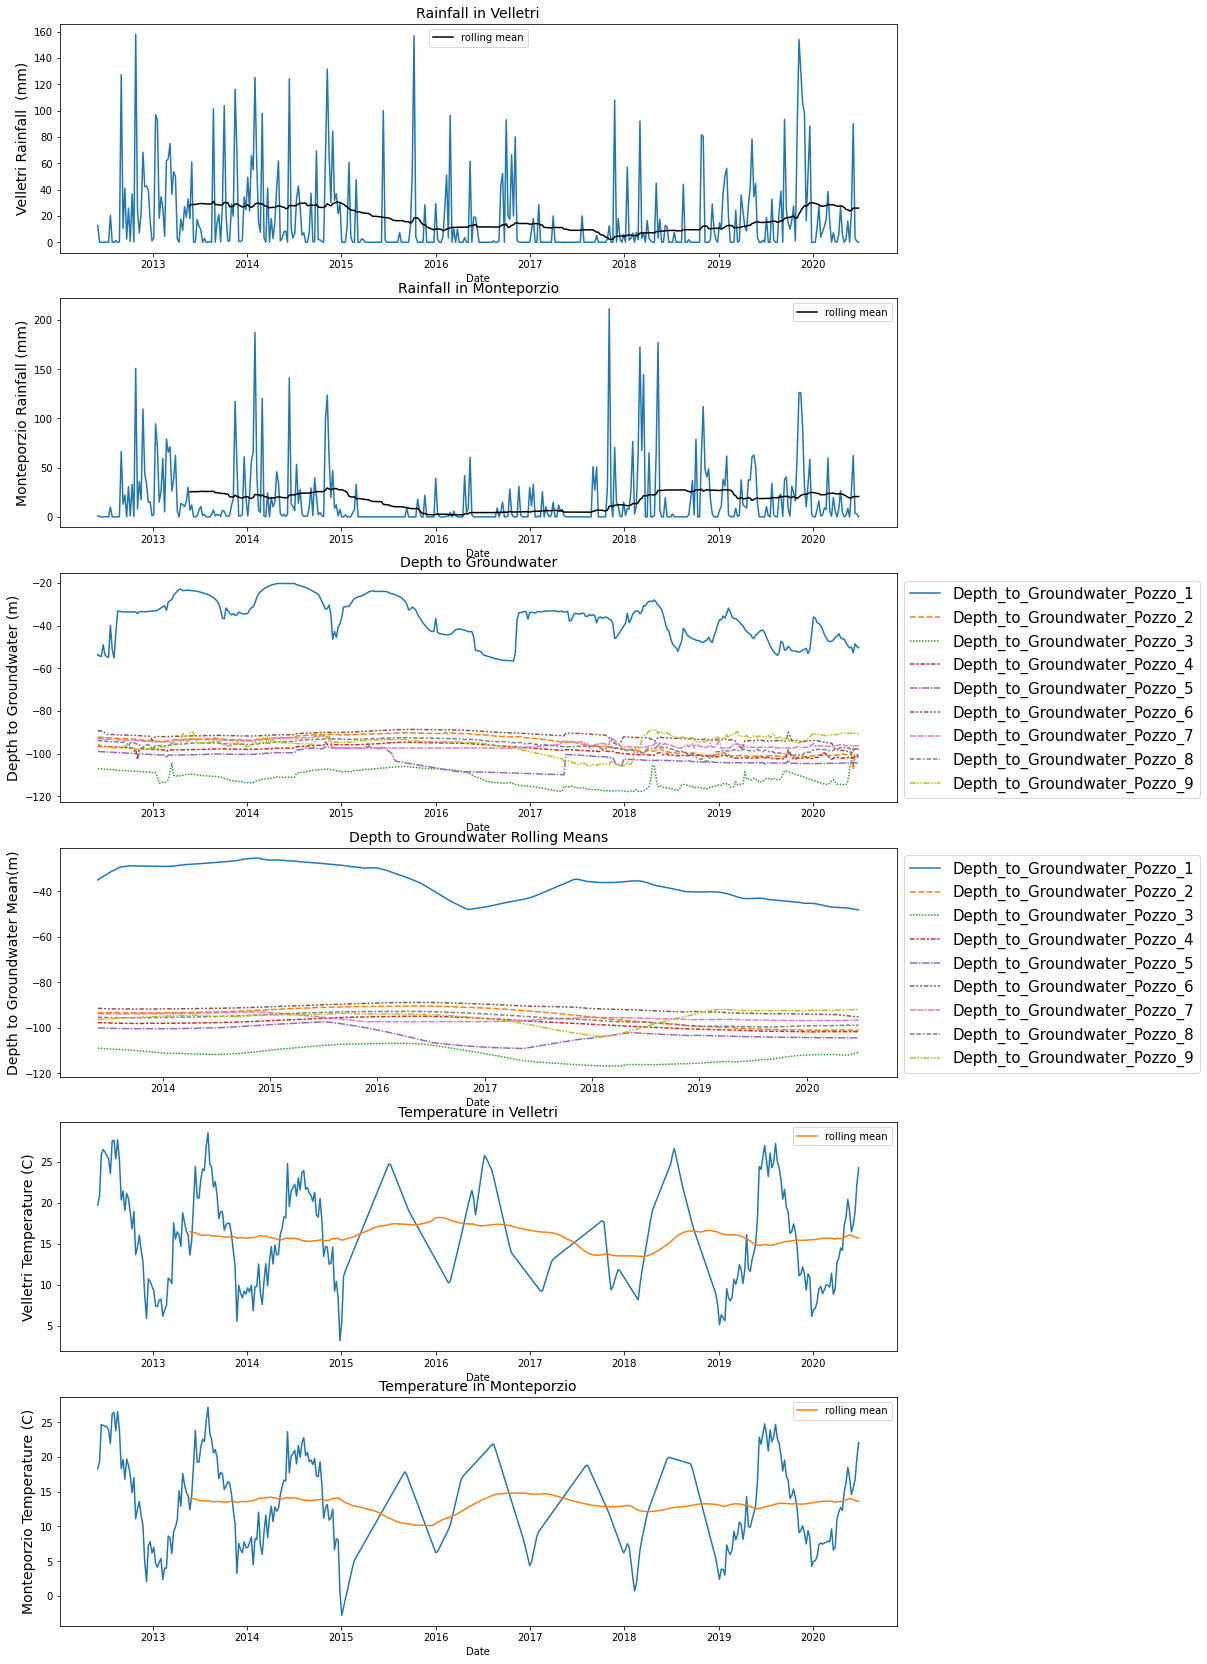

In [15]:
rolling_window = 52 # weeks

fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 25))
plt.subplots_adjust(bottom=0.01, top=0.9)

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Velletri'], ax=ax[0])
sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Velletri'].rolling(rolling_window).mean(), 
             ax=ax[0], color='black', label='rolling mean')
ax[0].set_title('Rainfall in Velletri', fontsize=14)
ax[0].set_ylabel('Velletri Rainfall  (mm)', fontsize=14)

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Monteporzio'], ax=ax[1])
sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Monteporzio'].rolling(rolling_window).mean(), 
             ax=ax[1], color='black', label='rolling mean')
ax[1].set_title('Rainfall in Monteporzio', fontsize=14)
ax[1].set_ylabel('Monteporzio Rainfall (mm)', fontsize=14)

groundwater_data = dog_no_vol_downsampled.iloc[:, np.r_[0,1:10]].set_index('Date')
sns.lineplot(data=groundwater_data, ax=ax[2])
ax[2].set_title('Depth to Groundwater', fontsize=14)
ax[2].set_ylabel('Depth to Groundwater (m)', fontsize=14)
ax[2].legend(bbox_to_anchor=(1,1), loc='upper left', prop={'size':15})

sns.lineplot(data=groundwater_data.rolling(rolling_window).mean(), ax=ax[3])
ax[3].set_title('Depth to Groundwater Rolling Means', fontsize=14)
ax[3].set_ylabel('Depth to Groundwater Mean(m)', fontsize=14)
ax[3].legend(bbox_to_anchor=(1,1), loc='upper left', prop={'size':15})

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Velletri'], ax=ax[4])
sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Velletri'].rolling(rolling_window).mean(), ax=ax[4], label='rolling mean')
ax[4].set_title('Temperature in Velletri', fontsize=14)
ax[4].set_ylabel('Velletri Temperature (C)', fontsize=14)

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Monteporzio'], ax=ax[5])
sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Monteporzio'].rolling(rolling_window).mean(), ax=ax[5], label='rolling mean')
ax[5].set_title('Temperature in Monteporzio', fontsize=14)
ax[5].set_ylabel('Monteporzio Temperature (C)', fontsize=14)

plt.show()

It looks like all of the features and the target exhibit trends. There are a few depths to groundwater which have a constant mean so we may have to test these differently, but overall we can use the ADF critical values for the regression equation where there is a non-zero mean and a trend. The regression equation can be found in the References section in the first link.

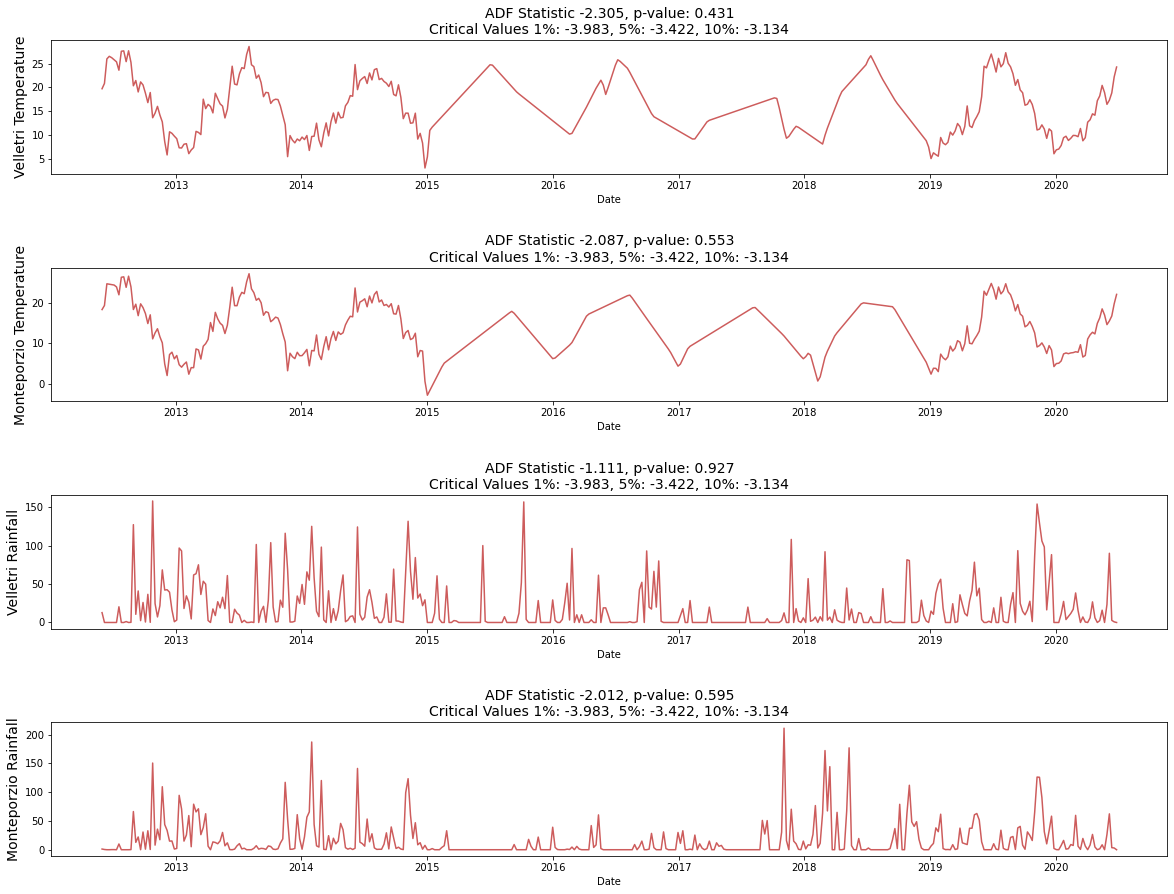

In [16]:
# From Leonie's notebook found here: https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting#Data-Preprocessing

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series, regression='ct', autolag='t-stat', maxlag=52)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=dog_no_vol_downsampled.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    
    
fig, ax = plt.subplots(4, 1, figsize=(20,15))
plt.subplots_adjust(hspace=0.7)
visualize_adfuller_results(dog_no_vol_downsampled.Temperature_Velletri.values, 'Velletri Temperature', ax[0])
visualize_adfuller_results(dog_no_vol_downsampled.Temperature_Monteporzio.values, 'Monteporzio Temperature', ax[1])
visualize_adfuller_results(dog_no_vol_downsampled.Rainfall_Velletri.values, 'Velletri Rainfall', ax[2])
visualize_adfuller_results(dog_no_vol_downsampled.Rainfall_Monteporzio.values, 'Monteporzio Rainfall', ax[3])

It appears that none of the features are stationary and we accept the null hypothesis. However, I achieved this result by modifying a few of the parameters to match our data. If we were to use the adfuller() function with the default parameters then all of the features would have been seen as stationary.

adfuller() parameters:
- regression='ct'
- autolag='t-stat'
- maxlag=52

I changed the regression to 'ct' because our data should include the constant term and the trend term in the regression equation. This is because our data has a non-zero mean and exhibits a trend or non-constant mean.

I changed the autolag to 't-stat' because this starts with maxlag instead of 0 and drops the lag until it is significant using a 5%-sized test.

I changed the maxlag to 52 because we are looking at weekly data and if our lag is not large enough then the ADF will miss the seasonality in the data for each year.

To confirm the stationarity of the data we will also test it using a KPSS test.

### KPSS Test

A KPSS test has the null hypothesis and alternate hypothesis which is switched from ADF.

**Null Hypothesis:** Accept the Null Hypothesis and the data is stationary.

**Alternate Hypothesis:** Reject the Null Hypothesis and the data is not stationary.

This uses the p-value and critical values as well to judge whether or not to accept or reject the Null Hypothesis.

We can reject the null hypothesis based on the p-value or if the test statistic is less than a critical value.

**p-value > 0.05:** Accept the Null Hypothesis and the data is stationary.

**p-value < 0.05:** Reject the Null Hypothesis and the data is non-stationary.

#### OR

**KPSS Statistic > Critical Value:** Accept the Null Hypothesis and the data is stationary.

**KPSS Statistic < Critical Value:** Reject the Null Hypothesis and the data is non-stationary.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1882: InterpolationWarning

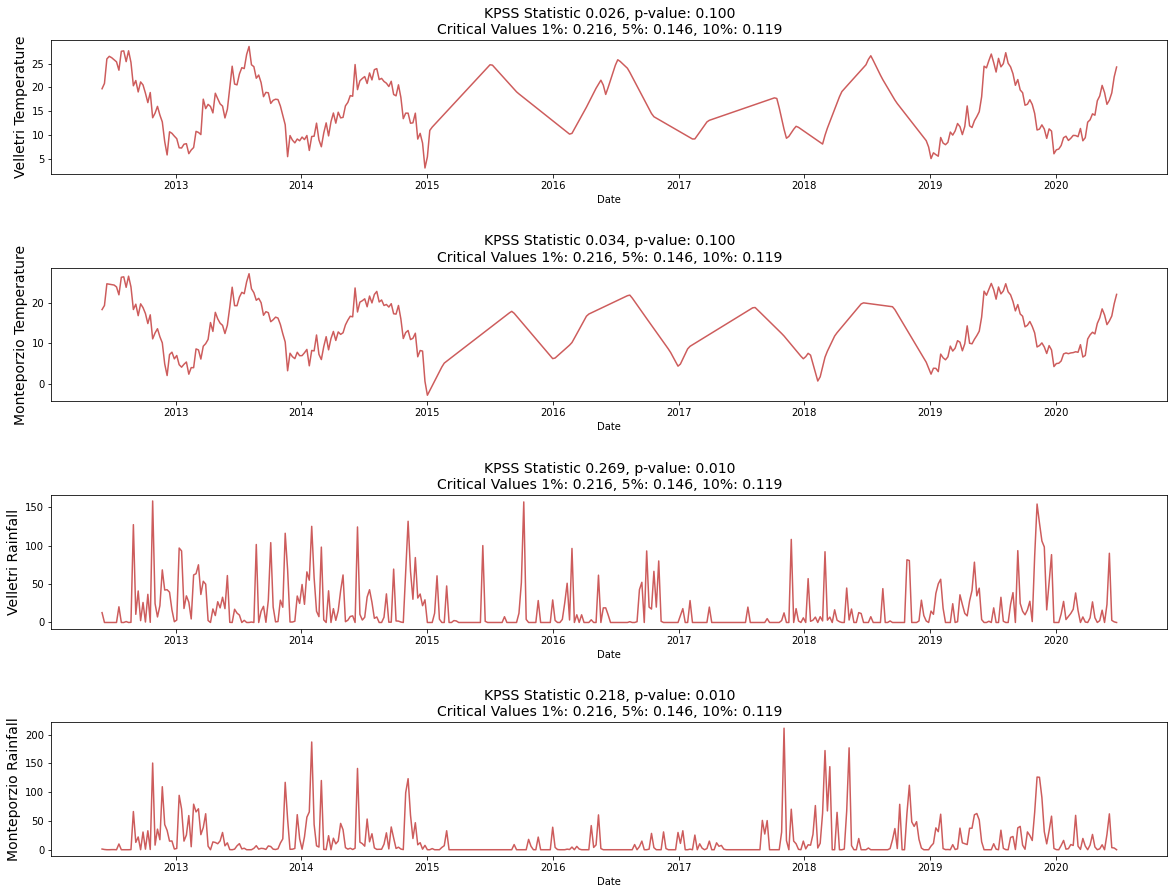

In [17]:
def visualize_kpss_results(series, title, ax):
    result = kpss(series, regression='ct', nlags='auto')
    significance_level = 0.05
    kpss_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[3]['1%']
    crit_val_5 = result[3]['5%']
    crit_val_10 = result[3]['10%']

    if (p_val < significance_level) & ((kpss_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (kpss_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (kpss_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=dog_no_vol_downsampled.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'KPSS Statistic {kpss_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    
    
fig, ax = plt.subplots(4, 1, figsize=(20,15))
plt.subplots_adjust(hspace=0.7)
visualize_kpss_results(dog_no_vol_downsampled.Temperature_Velletri.values, 'Velletri Temperature', ax[0])
visualize_kpss_results(dog_no_vol_downsampled.Temperature_Monteporzio.values, 'Monteporzio Temperature', ax[1])
visualize_kpss_results(dog_no_vol_downsampled.Rainfall_Velletri.values, 'Velletri Rainfall', ax[2])
visualize_kpss_results(dog_no_vol_downsampled.Rainfall_Monteporzio.values, 'Monteporzio Rainfall', ax[3])

There are some conflicting results between the p-values and the critical values for both the ADF test and the KPSS test, however, I believe that all of these features are non-stationary. This is because the rainfall for both the ADF and the KPSS tests both have low p-values and high critical values. I think this is because they do not exhibit a strong trend, but have a non-constant mean. This means that they are not stationary, but the lack of the trend causes the KPSS and ADF statistics to evaluate the data to be stationary. On the other hand, the trend due to seasonality of the temperature, but a constant mean causes the opposite, where the KPSS and ADF detect the trend and evaluate the data as non-stationary.

This is just a rough idea of how I think the results should be evaluated and why. This may deserve more exploration to find the mathematical backing in the future. For now, I will just assume that the features are non-stationary in different ways.

## Transforming the Data

Now we will try to transform the data to make it a stationary dataset. To make the data stationary we need to make the variance constant and make the mean stationary. To address the variance we would use a transformation such as applying a log or square root to the data and to make the mean stationary we would difference the data or subtract the current value from the previous.

### Transformation

First, we will look at how the variance changes by plotting the rolling standard deviation of the features.

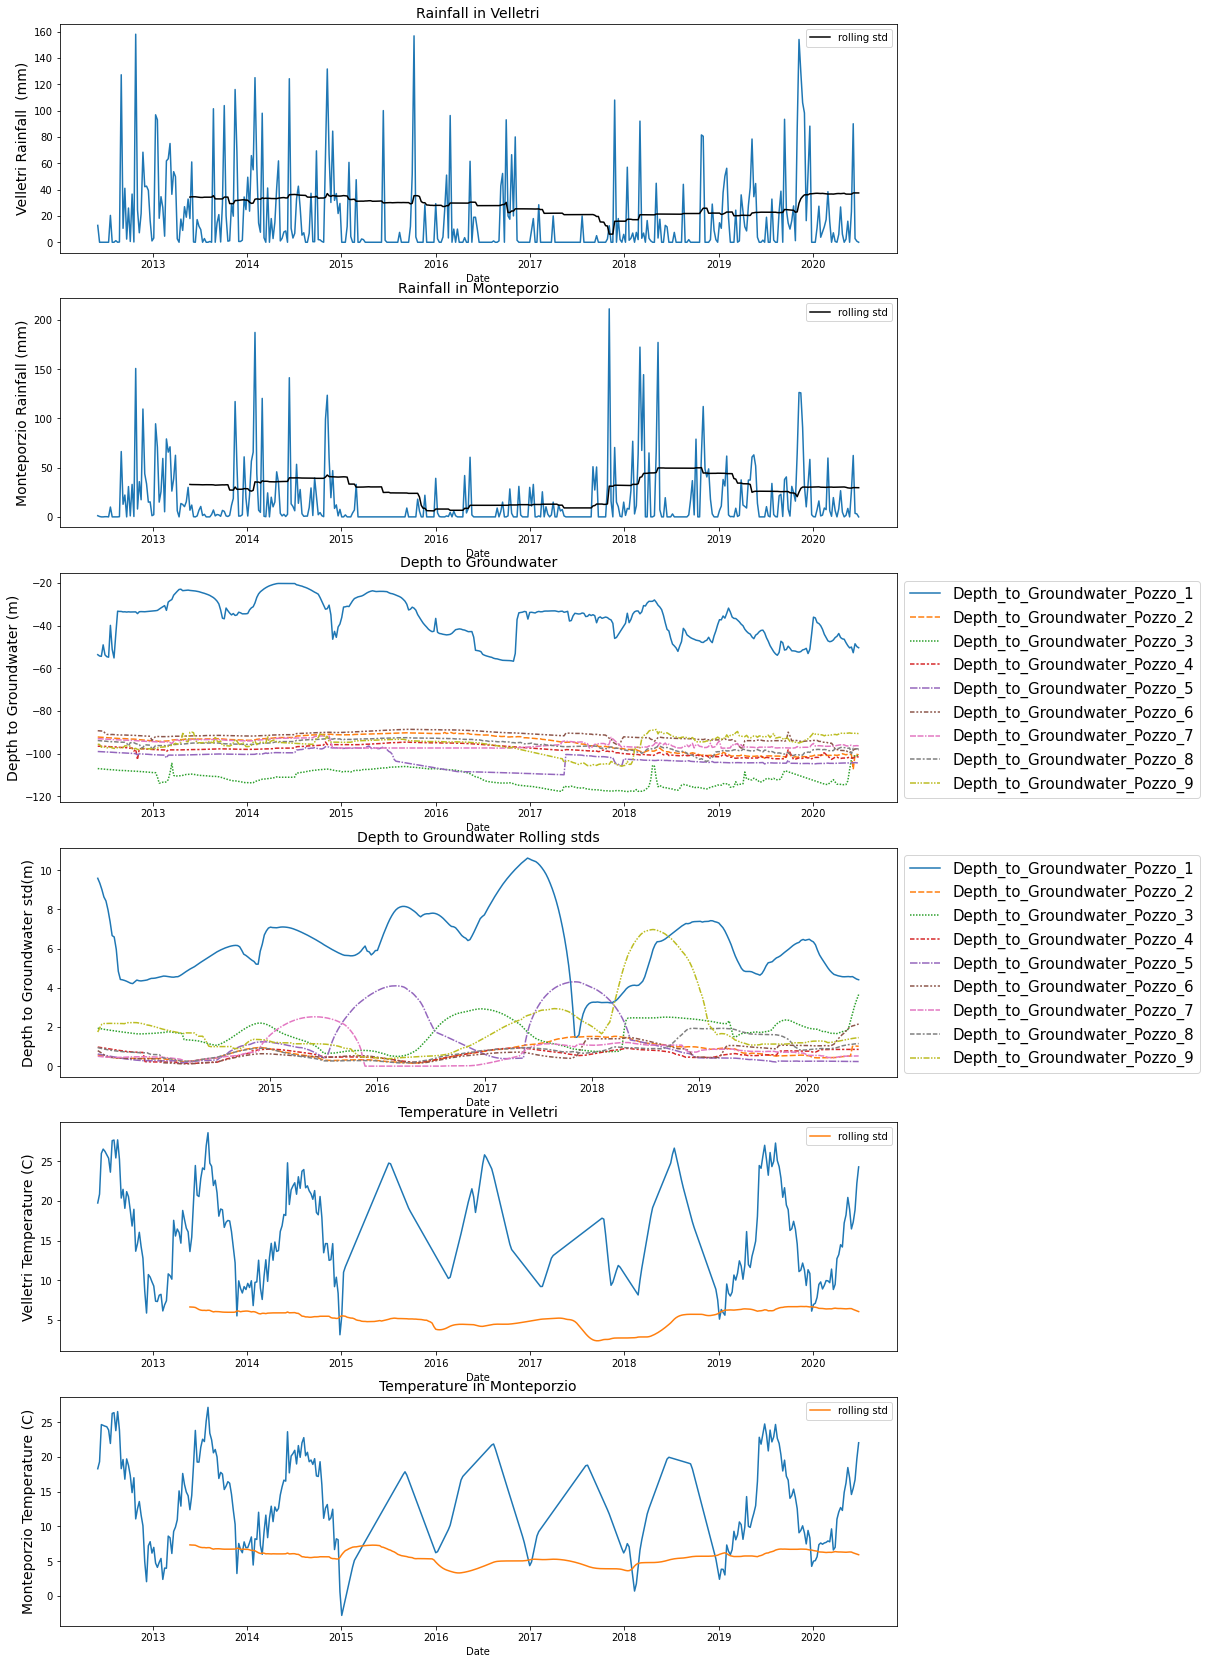

In [18]:
rolling_window = 52 # weeks

fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 25))
plt.subplots_adjust(bottom=0.01, top=0.9)

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Velletri'], ax=ax[0])
sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Velletri'].rolling(rolling_window).std(),
             ax=ax[0], color='black', label='rolling std')
ax[0].set_title('Rainfall in Velletri', fontsize=14)
ax[0].set_ylabel('Velletri Rainfall  (mm)', fontsize=14)

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Monteporzio'], ax=ax[1])
sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Rainfall_Monteporzio'].rolling(rolling_window).std(),
             ax=ax[1], color='black', label='rolling std')
ax[1].set_title('Rainfall in Monteporzio', fontsize=14)
ax[1].set_ylabel('Monteporzio Rainfall (mm)', fontsize=14)

groundwater_data = dog_no_vol_downsampled.iloc[:, np.r_[0,1:10]].set_index('Date')
sns.lineplot(data=groundwater_data, ax=ax[2])
ax[2].set_title('Depth to Groundwater', fontsize=14)
ax[2].set_ylabel('Depth to Groundwater (m)', fontsize=14)
ax[2].legend(bbox_to_anchor=(1,1), loc='upper left', prop={'size':15})

sns.lineplot(data=groundwater_data.rolling(rolling_window).std(), ax=ax[3])
ax[3].set_title('Depth to Groundwater Rolling stds', fontsize=14)
ax[3].set_ylabel('Depth to Groundwater std(m)', fontsize=14)
ax[3].legend(bbox_to_anchor=(1,1), loc='upper left', prop={'size':15})

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Velletri'], ax=ax[4])
sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Velletri'].rolling(rolling_window).std(), ax=ax[4], label='rolling std')
ax[4].set_title('Temperature in Velletri', fontsize=14)
ax[4].set_ylabel('Velletri Temperature (C)', fontsize=14)

sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Monteporzio'], ax=ax[5])
sns.lineplot(x=dog_no_vol_downsampled['Date'], y=dog_no_vol_downsampled['Temperature_Monteporzio'].rolling(rolling_window).std(), ax=ax[5], label='rolling std')
ax[5].set_title('Temperature in Monteporzio', fontsize=14)
ax[5].set_ylabel('Monteporzio Temperature (C)', fontsize=14)

plt.show()

As we can see from looking at the rolling standard deviation, the variance is not constant over the frequency of each year. This means that we will want to transform the data. Since the mean is also non-constant then I will take the first order difference of the data as well.

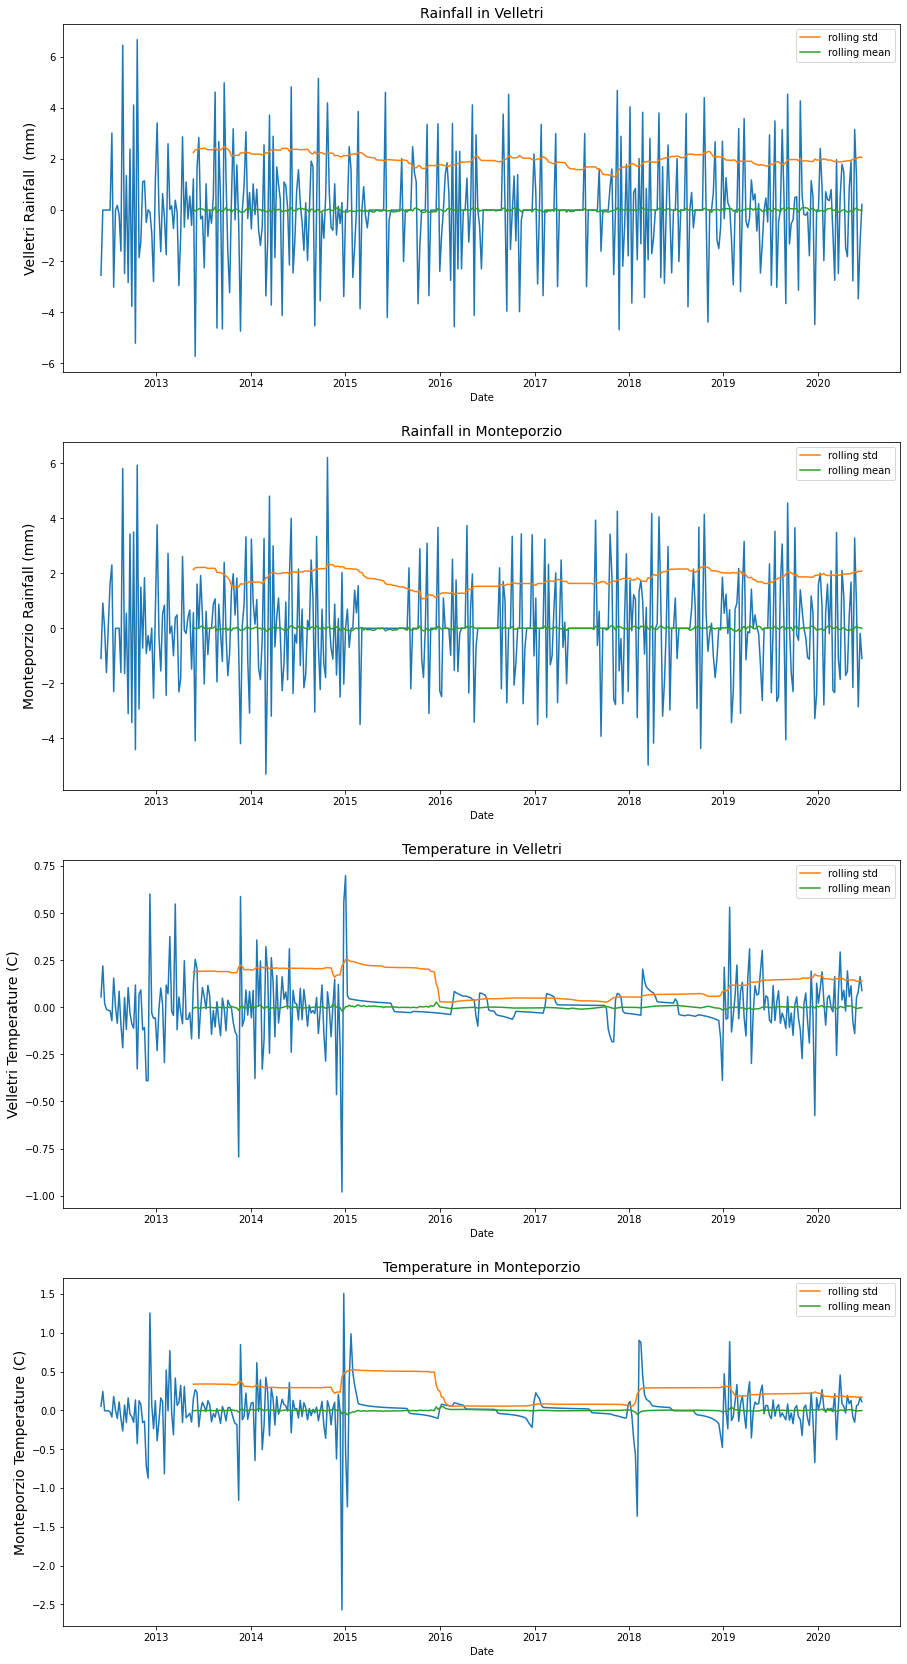

In [19]:
dog_no_vol_transformed = dog_no_vol_downsampled.replace([0], 1)
dog_no_vol_transformed = np.log(abs(dog_no_vol_transformed.iloc[:, 10:14]))
dog_no_vol_diff = np.diff(dog_no_vol_transformed, axis=0)
dog_no_vol_diff = pd.DataFrame(dog_no_vol_diff, columns=dog_no_vol_downsampled.iloc[:, 10:14].columns)
dog_no_vol_diff['Date'] = dog_no_vol_downsampled['Date']
rolling_window = 52 # weeks

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))
plt.subplots_adjust(bottom=0.01, top=0.9)

sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Rainfall_Velletri'], ax=ax[0])
sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Rainfall_Velletri'].rolling(rolling_window).std(), ax=ax[0], label='rolling std')
sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Rainfall_Velletri'].rolling(rolling_window).mean(), ax=ax[0], label='rolling mean')
ax[0].set_title('Rainfall in Velletri', fontsize=14)
ax[0].set_ylabel('Velletri Rainfall  (mm)', fontsize=14)

sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Rainfall_Monteporzio'], ax=ax[1])
sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Rainfall_Monteporzio'].rolling(rolling_window).std(), ax=ax[1], label='rolling std')
sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Rainfall_Monteporzio'].rolling(rolling_window).mean(), ax=ax[1], label='rolling mean')
ax[1].set_title('Rainfall in Monteporzio', fontsize=14)
ax[1].set_ylabel('Monteporzio Rainfall (mm)', fontsize=14)

sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Temperature_Velletri'], ax=ax[2])
sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Temperature_Velletri'].rolling(rolling_window).std(), ax=ax[2], label='rolling std')
sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Temperature_Velletri'].rolling(rolling_window).mean(), ax=ax[2], label='rolling mean')

ax[2].set_title('Temperature in Velletri', fontsize=14)
ax[2].set_ylabel('Velletri Temperature (C)', fontsize=14)

sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Temperature_Monteporzio'], ax=ax[3])
sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Temperature_Monteporzio'].rolling(rolling_window).std(), ax=ax[3], label='rolling std')
sns.lineplot(x=dog_no_vol_diff['Date'], y=dog_no_vol_diff['Temperature_Monteporzio'].rolling(rolling_window).mean(), ax=ax[3], label='rolling mean')

ax[3].set_title('Temperature in Monteporzio', fontsize=14)
ax[3].set_ylabel('Monteporzio Temperature (C)', fontsize=14)

plt.show()

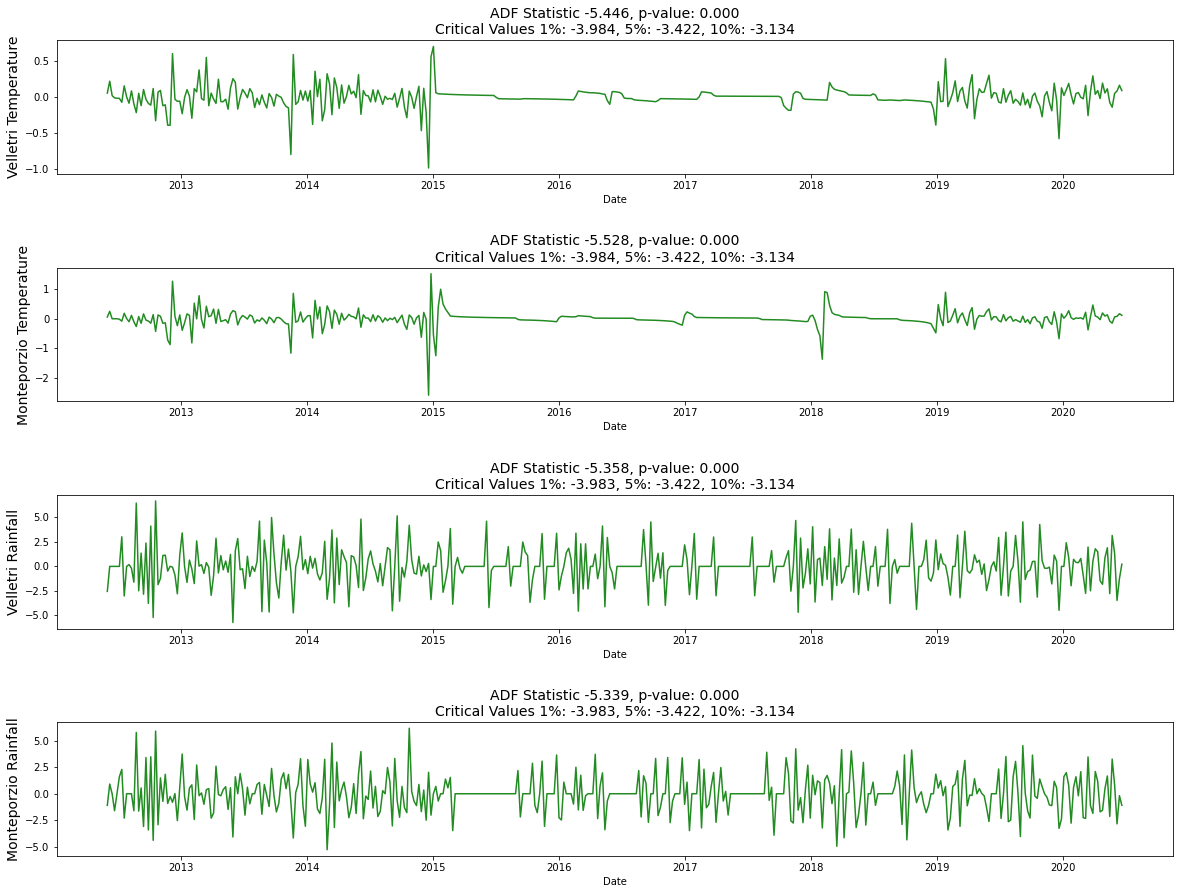

In [20]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series, regression='ct', autolag='t-stat', maxlag=52)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=dog_no_vol_diff.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

fig, ax = plt.subplots(4, 1, figsize=(20,15))
plt.subplots_adjust(hspace=0.7)
visualize_adfuller_results(dog_no_vol_diff.Temperature_Velletri.values, 'Velletri Temperature', ax[0])
visualize_adfuller_results(dog_no_vol_diff.Temperature_Monteporzio.values, 'Monteporzio Temperature', ax[1])
visualize_adfuller_results(dog_no_vol_diff.Rainfall_Velletri.values, 'Velletri Rainfall', ax[2])
visualize_adfuller_results(dog_no_vol_diff.Rainfall_Monteporzio.values, 'Monteporzio Rainfall', ax[3])

As we can see differencing the data and applying a log transformation to the data made it stationary according to the ADF test. Now that we have made our data stationary, we can start to look at feature engineering.

# Feature Engineering

To look at the relationship of the features to groundwater, we can decompose the time series into four characteristics: Level, Trend, Seasonality, and Noise. By looking at these features we could see if there is any relationships in the features which would indicate a relationship such as the seasonality being inverse or the same or trends matching each other.

In [21]:
decompose_cols = dog_no_vol_downsampled.columns[1:]

for col in decompose_cols:
    decomp = seasonal_decompose(dog_no_vol_downsampled[col], period=52, model='additive', extrapolate_trend='freq')
    dog_no_vol_downsampled[f'{col}_trend'] = decomp.trend
    dog_no_vol_downsampled[f'{col}_seasonal'] = decomp.seasonal
    
dog_no_vol_downsampled

Date  Depth_to_Groundwater_Pozzo_1  Depth_to_Groundwater_Pozzo_2  \
0   2012-06-01                    -53.658571                    -92.210000   
1   2012-06-08                    -54.282857                    -92.271429   
2   2012-06-15                    -54.431429                    -92.355714   
3   2012-06-22                    -49.052857                    -92.410000   
4   2012-06-29                    -53.730000                    -92.445714   
..         ...                           ...                           ...   
417 2020-05-29                    -50.080000                   -100.411429   
418 2020-06-05                    -52.752857                   -107.317143   
419 2020-06-12                    -48.558571                   -100.304286   
420 2020-06-19                    -49.861429                   -100.350000   
421 2020-06-26                    -50.412000                   -100.518000   

     Depth_to_Groundwater_Pozzo_3  Depth_to_Groundwater_Pozzo_4  \
0                     -106.992857                    -96.517143   
1                     -107.055714                    -96.541429   
2                     -107.155714                    -96.535714   
3                     -107.224286                    -96.625714   
4                     -107.291429                    -96.565714   
..                            ...                           ...   
417                   -102.722143                   -102.028571   
418                   -101.422857                   -102.076667   
419                   -100.912143                   -101.477619   
420                   -100.966429                   -101.478571   
421                   -101.013000                   -101.570000   

     Depth_to_Groundwater_Pozzo_5  Depth_to_Groundwater_Pozzo_6  \
0                      -99.002857                    -89.271429   
1                      -99.042857                    -89.330000   
2                      -99.092857                    -89.395714   
3                      -99.128571                    -89.447143   
4                      -99.174286                    -90.310000   
..                            ...                           ...   
417                   -104.328571                    -99.057143   
418                   -104.308571                    -98.355000   
419                   -104.188571                    -97.738571   
420                   -104.305714                    -98.075714   
421                   -104.302000                    -98.258000   

     Depth_to_Groundwater_Pozzo_7  Depth_to_Groundwater_Pozzo_8  \
0                      -92.962857                    -93.854286   
1                      -93.018571                    -93.920000   
2                      -93.091429                    -94.014286   
3                      -93.144286                    -94.074286   
4                      -93.190000                    -94.114286   
..                            ...                           ...   
417                    -96.065714                   -100.095714   
418                    -96.377143                    -97.482857   
419                    -96.310000                    -97.697143   
420                    -96.245714                    -97.740000   
421                    -96.334000                    -97.772000   

     Depth_to_Groundwater_Pozzo_9  ...  Depth_to_Groundwater_Pozzo_9_trend  \
0                      -95.568571  ...                          -97.197485   
1                      -95.691429  ...                          -97.159455   
2                      -96.988571  ...                          -97.121424   
3                      -96.931429  ...                          -97.083393   
4                      -96.912857  ...                          -97.045362   
..                            ...  ...                                 ...   
417                    -90.474286  ...                          -91.956212   
418                    -90.382857 

I made new columns for the trend and seasonality of each feature. Since we are trying to predict depth to groundwater then we will want to compare the trends and seasonality of our temperature and rainfall to the depth to groundwater to see if there are any relationships which could be obvious when visualized.

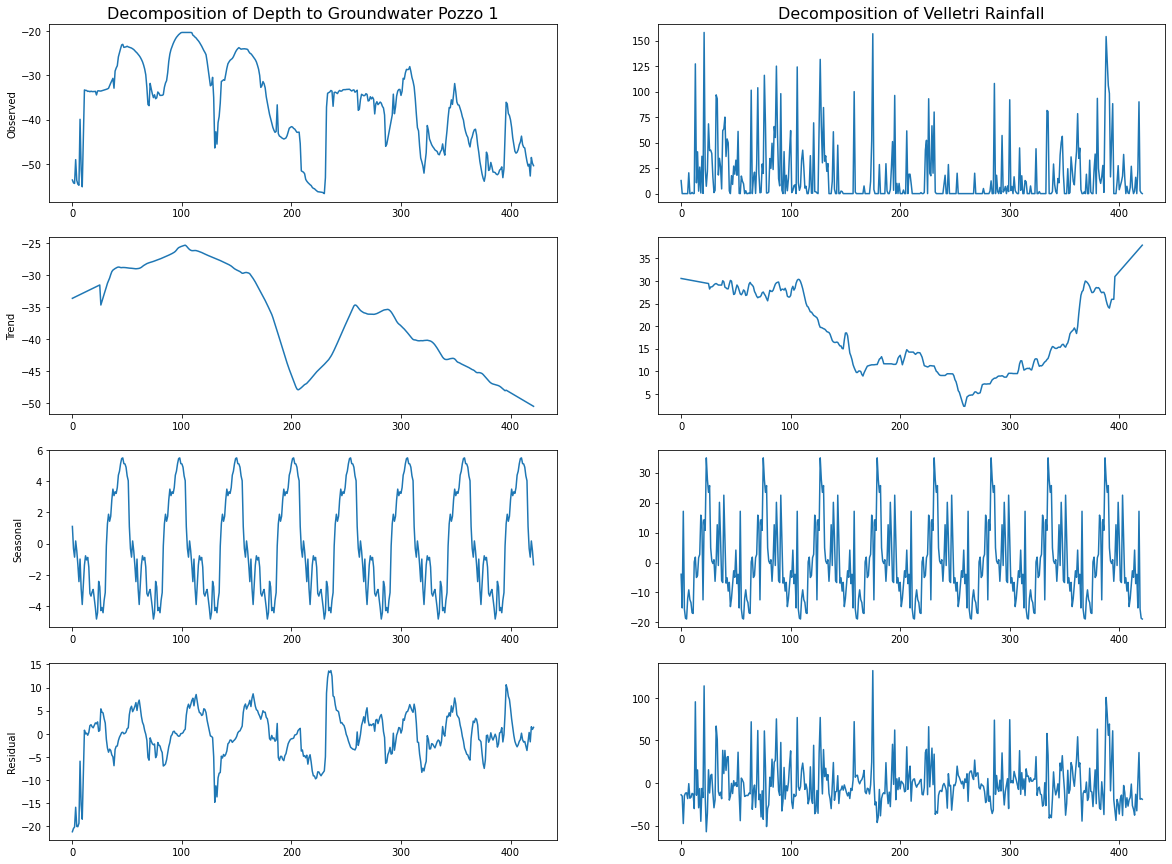

In [22]:
decomposition = {col: seasonal_decompose(dog_no_vol_downsampled[col], period=52, model='additive', extrapolate_trend='freq') for col in decompose_cols}
fig, ax = plt.subplots(4, 2, figsize=(20, 15))

ax[0,0].set_title('Decomposition of Depth to Groundwater Pozzo 1', fontsize=16)
decomposition['Depth_to_Groundwater_Pozzo_1'].observed.plot(ax=ax[0, 0])
decomposition['Depth_to_Groundwater_Pozzo_1'].trend.plot(ax=ax[1, 0])
decomposition['Depth_to_Groundwater_Pozzo_1'].seasonal.plot(ax=ax[2,0])
decomposition['Depth_to_Groundwater_Pozzo_1'].resid.plot(ax=ax[3, 0])

ax[0,1].set_title('Decomposition of Velletri Rainfall', fontsize=16)
decomposition['Rainfall_Velletri'].observed.plot(ax=ax[0, 1])
decomposition['Rainfall_Velletri'].trend.plot(ax=ax[1, 1])
decomposition['Rainfall_Velletri'].seasonal.plot(ax=ax[2, 1])
decomposition['Rainfall_Velletri'].resid.plot(ax=ax[3, 1])

ax[0,0].set_ylabel('Observed')
ax[1,0].set_ylabel('Trend')
ax[2,0].set_ylabel('Seasonal')
ax[3,0].set_ylabel('Residual')

plt.show()

By looking at the decomposition, we can see that the rainfall might be related in terms of seasonality. It looks like the peaks of the rainfall may be lagged behind the peaks of the depth to groundwater. Let's see if we can match these two if we can match these two by shifting the seasonal data of Velletri Rainfall around.

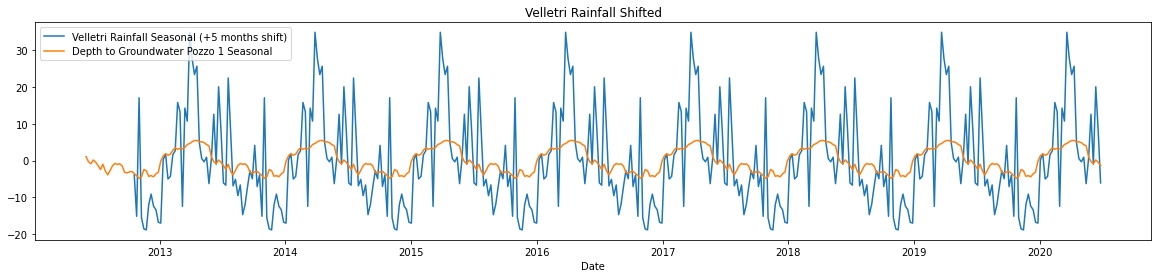

In [23]:
rain_season = dog_no_vol_downsampled['Rainfall_Velletri_seasonal']
depth_season = dog_no_vol_downsampled['Depth_to_Groundwater_Pozzo_1_seasonal']

weeks_in_month = 4
rain_season_shift = rain_season.shift(5*weeks_in_month)

fig, ax = plt.subplots(1, 1, figsize=(20,4))
sns.lineplot(x=dog_no_vol_downsampled.Date, y=rain_season_shift, ax=ax, label='Velletri Rainfall Seasonal (+5 months shift)')
sns.lineplot(x=dog_no_vol_downsampled.Date, y=depth_season, ax=ax, label='Depth to Groundwater Pozzo 1 Seasonal')
ax.set_ylabel('')
ax.set_title('Velletri Rainfall Shifted')
plt.show()

In [24]:
rain_season_shift.corr(depth_season)

0.5621501590440819

From this graph, we can see that after shifting the rainfall in Velletri ahead by 5 months then the peaks begin to line up. This could show that the amount of rainfall could be correlated to the depth to the groundwater 5 months later. We know that rainfall probably will not instantly affect the depth so this makes sense. I chose to line up the peaks with the peaks because the depth to the groundwater should decrease after a lot of rain while it will increase after a period of no rain.

In [25]:
dog_no_vol_fin = dog_no_vol_downsampled.iloc[:, 0:14].copy()
dog_no_vol_diff = np.diff(dog_no_vol_fin.iloc[:, 1:14], axis=0)
dog_no_vol_fin.iloc[:, 1:14] = pd.DataFrame(dog_no_vol_diff, columns=dog_no_vol_fin.iloc[:, 1:14].columns)
dog_no_vol_fin.dropna(inplace=True)
dog_no_vol_fin

Date  Depth_to_Groundwater_Pozzo_1  Depth_to_Groundwater_Pozzo_2  \
0   2012-06-01                     -0.624286                     -0.061429   
1   2012-06-08                     -0.148571                     -0.084286   
2   2012-06-15                      5.378571                     -0.054286   
3   2012-06-22                     -4.677143                     -0.035714   
4   2012-06-29                     -0.867143                     -0.071429   
..         ...                           ...                           ...   
416 2020-05-22                      0.404286                     -0.105714   
417 2020-05-29                     -2.672857                     -6.905714   
418 2020-06-05                      4.194286                      7.012857   
419 2020-06-12                     -1.302857                     -0.045714   
420 2020-06-19                     -0.550571                     -0.168000   

     Depth_to_Groundwater_Pozzo_3  Depth_to_Groundwater_Pozzo_4  \
0                       -0.062857                     -0.024286   
1                       -0.100000                      0.005714   
2                       -0.068571                     -0.090000   
3                       -0.067143                      0.060000   
4                       -0.091429                     -0.125714   
..                            ...                           ...   
416                      4.725357                     -0.375714   
417                      1.299286                     -0.048095   
418                      0.510714                      0.599048   
419                     -0.054286                     -0.000952   
420                     -0.046571                     -0.091429   

     Depth_to_Groundwater_Pozzo_5  Depth_to_Groundwater_Pozzo_6  \
0                       -0.040000                     -0.058571   
1                       -0.050000                     -0.065714   
2                       -0.035714                     -0.051429   
3                       -0.045714                     -0.862857   
4                       -0.054286                     -0.672222   
..                            ...                           ...   
416                      0.000000                      0.370000   
417                      0.020000                      0.702143   
418                      0.120000                      0.616429   
419                     -0.117143                     -0.337143   
420                      0.003714                     -0.182286   

     Depth_to_Groundwater_Pozzo_7  Depth_to_Groundwater_Pozzo_8  \
0                       -0.055714                     -0.065714   
1                       -0.072857                     -0.094286   
2                       -0.052857                     -0.060000   
3                       -0.045714                     -0.040000   
4                       -0.068571                     -0.100159   
..                            ...                           ...   
416                      0.065714                     -2.747143   
417                     -0.311429                      2.612857   
418                      0.067143                     -0.214286   
419                      0.064286                     -0.042857   
420                     -0.088286                     -0.032000   

     Depth_to_Groundwater_Pozzo_9  Temperature_Monteporzio  \
0                       -0.122857                 1.010000   
1                       -1.297143                 5.341429   
2                        0.057143                -0.108571   
3                        0.018571                -0.120000   
4                       -0.297143                -0.078571   
..                            ...                      ...   
416                     -0.178571                -2.392857   
417                      0.091429                 0.910000   
418                     -0.104286                 1.210000   
419                      0.012857     

# Modeling

Since the goal of this project is to predict the depth to groundwater while also looking at how the features affect this depth to groundwater, I will be using a Random Forest Classifier to try to forecast the depth to groundwater based on the features. The Random Forest Classifier is useful because it is not just a black box and we can see how important each feature was for classification.

I plan on splitting the dog_no_vol_fin dataset into an 80/15/5 split for the train, validation, and test set.

In [26]:
def train_val_test_split(df, train_split, val_split):
    
    rows = df.shape[0]
    split1 = int(np.floor(train_split*rows))
    split2 = int(np.floor(val_split*rows) + split1)
    
    train = df.iloc[0:split1, :]
    val = df.iloc[split1:split2, :]
    test = df.iloc[split2:, :]
    
    return train, val, test


split_data = train_val_test_split(dog_no_vol_fin, 0.8, 0.15)
train = split_data[0]
val = split_data[1]
test = split_data[2]

forecast_data = train_val_test_split(dog_no_vol, 0.8, 0.15)
train_forecast = forecast_data[0]
val_forecast = forecast_data[1]
test_forecast = forecast_data[2]

To get a base understanding of how Random Forest will fit the data without walk forward validation, I first tried to fit the model normally without using past data for the depth to groundwater. 

MAE =  3.968587238334968
[0.3115158  0.27175752 0.30855431 0.10817237]
Index(['Temperature_Monteporzio', 'Temperature_Velletri', 'Rainfall_Velletri',
       'Rainfall_Monteporzio'],
      dtype='object')


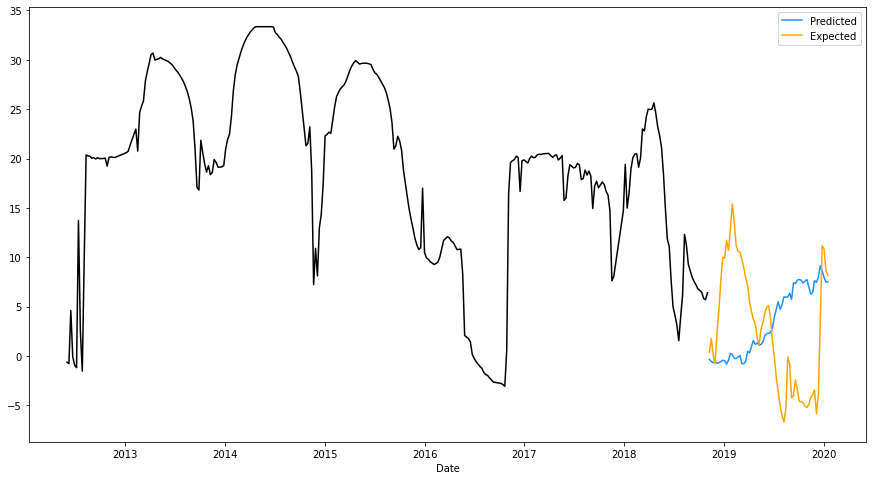

In [27]:
trainX, trainY = train.iloc[:, 10:14].values, train.iloc[:, 1].values
valX, valY = val.iloc[:, 10:14].values, val.iloc[:, 1].values.reshape(-1,1)

rf = RandomForestRegressor(n_estimators=1000, min_samples_leaf=10)
rf.fit(trainX, trainY)

predictions_from_features = rf.predict(valX).cumsum()

print('MAE = ', mean_absolute_error(valY, predictions_from_features))
print(rf.feature_importances_)
print(train.iloc[:, 10:14].columns)
fig, ax = plt.subplots(figsize=(15,8))

trainY = trainY.cumsum()
valY = valY.cumsum()

sns.lineplot(x=train.Date, y=trainY, color='black')
sns.lineplot(x=val.Date, y=predictions_from_features, color='dodgerblue',label='Predicted')
sns.lineplot(x=val.Date, y=valY, color='orange', label='Expected')
plt.show()

The data was time differenced to get rid of any trend or seasonality then converted back which is why there is a gap between the first line and the second line. As we can see, the Random Forest does not fit the data very well for anything between the beginning and the end. 

According to the features importance for the Random Forest, the most important feature is the temperature in Monteporzio. However, this may not be the most important considering the fit.

Next, we will try to forecast the data using walk forward validation which utilizes the past data and the predictions it makes to keep predicting the next point.

In [28]:
def walk_forward_validation(train, test):
    
    predictions = list()
    features_importance = np.ones(5)
    
    history = [x for x in train]
    
    for i in range(len(test)):
        
        testX, testY = test[i, :-1], test[i, -1]
        
        yhat, feat_imp = random_forest_forecast(history, testX)
        
        predictions.append(yhat)
        
        features_importance = np.vstack((features_importance, feat_imp))
        
        history.append(test[i])
        
        print(f'expected={testY}, predicted={yhat}')
        
    error = mean_absolute_error(test[:,1], predictions)
    return error, test[:, 1], predictions, features_importance

def random_forest_forecast(train, testX):
    
    train = np.asarray(train)
    
    trainX, trainY = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=100)
    
    model.fit(trainX, trainY)
    
    yhat = model.predict([testX])
    return yhat[0], model.feature_importances_

columns = [ 'Depth_to_Groundwater_Pozzo_1','Rainfall_Monteporzio', 'Rainfall_Velletri', 'Temperature_Monteporzio', 'Temperature_Velletri']

data = {'x':train_forecast[columns].shift(1), 'y':train_forecast['Depth_to_Groundwater_Pozzo_1'].shift(-1)}
val_data = {'x':val_forecast[columns].shift(1), 'y':val_forecast['Depth_to_Groundwater_Pozzo_1'].shift(-1)}

train_forecast_data = pd.concat(data, axis=1).dropna().values
val_forecast_data = pd.concat(val_data, axis=1).dropna().values
mae, y, predictions, features_importance = walk_forward_validation(train_forecast_data, val_forecast_data)

expected=-46.86, predicted=-45.84819090909085
expected=-46.7, predicted=-44.97664772727271
expected=-46.39, predicted=-45.26735681818177
expected=-46.39, predicted=-45.107543181818144
expected=-46.39, predicted=-44.72692803030298
expected=-46.39, predicted=-45.59477954545454
expected=-45.07, predicted=-46.212093181818176
expected=-44.98, predicted=-45.6111340909091
expected=-44.7, predicted=-44.74671136363632
expected=-44.57, predicted=-44.8089022727272
expected=-44.44, predicted=-44.465404545454504
expected=-44.44, predicted=-44.40466818181817
expected=-44.44, predicted=-44.41673181818182
expected=-44.44, predicted=-44.42056136363638
expected=-47.41, predicted=-44.36874318181819
expected=-52.33, predicted=-45.601206818181765
expected=-52.33, predicted=-46.67049318181814
expected=-52.33, predicted=-49.9885444444445
expected=-48.01, predicted=-51.302733333333315
expected=-47.66, predicted=-49.26878888888896
expected=-47.57, predicted=-44.04734217171715
expected=-47.42, predicted=-45.806

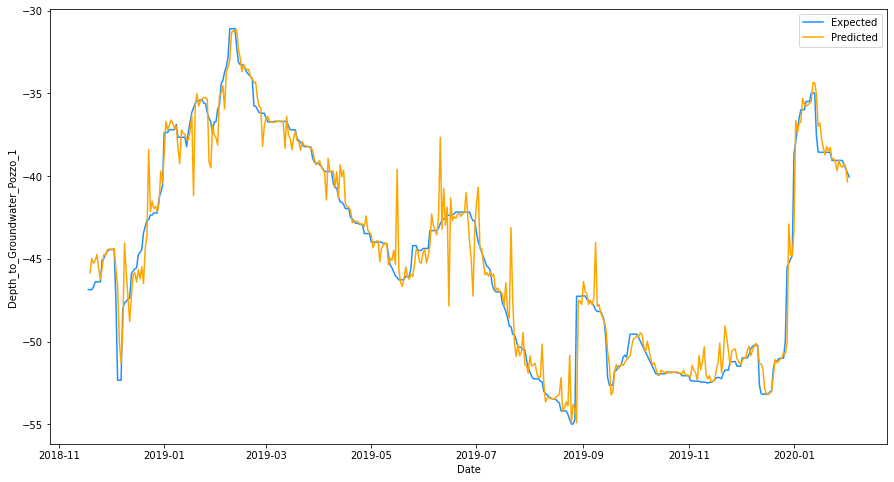

In [29]:
predictions_df = pd.DataFrame(predictions, columns=['Depth_to_Groundwater_Pozzo_1_Predictions'])
predictions_df['Date'] = val_forecast['Date'][1:-1].values

fig, ax = plt.subplots(1,1,figsize=(15,8))

sns.lineplot(x=val_forecast.Date, y=val_forecast.Depth_to_Groundwater_Pozzo_1, label='Expected', color='dodgerblue') #ax=ax[1])

sns.lineplot(x=predictions_df.Date, y=predictions_df.Depth_to_Groundwater_Pozzo_1_Predictions, label='Predicted', color='orange')

plt.show()

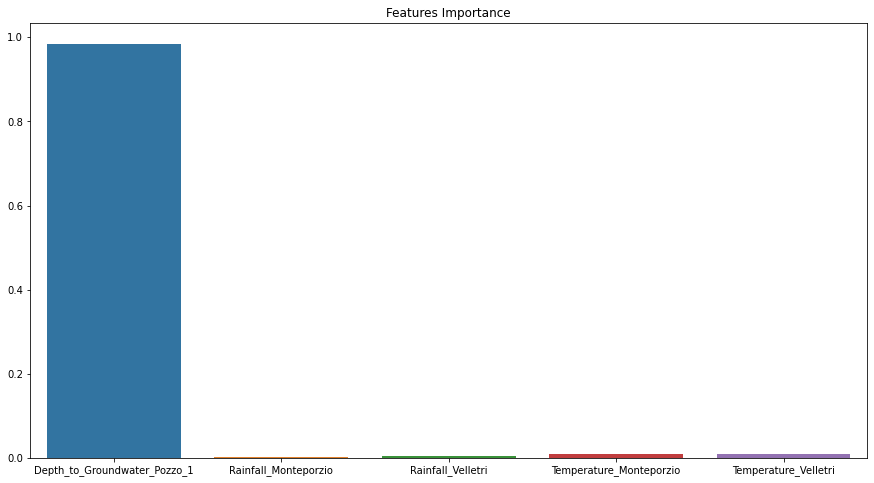

In [30]:
feature_avg_importance = np.average(features_importance, axis=0)

fig, ax = plt.subplots(figsize=(15,8))

sns.barplot(x=columns, y=feature_avg_importance)
plt.title('Features Importance')

plt.show()

The fit already looks much better even though there is some noise around the fit. I also recorded the features importance every time the Random Forest made a prediction to see if I could find a connection in the features to the depth to groundwater. As can be seen by the graph, the past data for the depth to the groundwater played the biggest part which is not a surprise. What came in second was the temperature in Monteporzio and Velletri. This may mean that there is more of a connection to the depth to groundwater through the temperature over the rainfall which is interesting.

# Conclusion

To preface, this was my first time series project and I learned quite a bit. It was interesting to see how much more one has to consider once you add a temporal quality to the data such as seasonality and trend. It was also fun to learn about testing for the stationarity and the trend using the ADF and KPSS statistical tests.

In this project I found that the best way to forecast the depth to groundwater was using the past data alongside the other features. I used the Random Forest specifically because I wanted to see if I could find any connections between the features like temperature and rainfall. Unfortunately, it came out rather inconclusive. It may be more dependent on the temperature vs. the rainfall, but the difference is quite low to really say confidently. 

I also tried to transform the data using a log transformation with the time differencing, but the results were much worse.

In the future, I want to revisit this project and try to model it using an LSTM neural network to see if I can get a better model. I would also like to play around with the other water sources to see if my Random Forest model and the LSTM model would be generalizable enough.

# References

Leonies Notebook: https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting 

- This notebook helped me get started with wrapping my head around time series data and how to approach a problem like this.

### ADF

https://iacopogarizio.com/projects/dickey-fuller-table-using-monte-carlo/

- This post explains the different types of regression equations used depending on the model and how the Dickey-Fuller critical values are found.

https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

- This helped me understand what each term means and how the ADF is structured.

### Random Forest for Forecasting

https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

- This explains walk-forward validation and has some useful functions which I tweaked.